<a href="https://www.kaggle.com/code/jaksanders/electric-load-forecasting-with-deep-learning?scriptVersionId=147970224" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Short-term residential load forecasting with Deep Learning

London households smart meter data

Thanks to my collaborator [Aaron Epel](http://www.linkedin.com/in/aaronepel/)!


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import IPython
import IPython.display
import glob
import time
import pickle
import sys
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")
randomState = 42 # tip of the cap to Douglas Adams

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-o

# Load Data

## Load half-hourly electric usage data
...for ~5k smart meters in London
[SmartMeter Energy Consumption Data in London Households](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households)

In [2]:
# load half-hourly electric usage data
# takes about four minutes, need to find somerthing faster like Dask?
# https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
# Get CSV files list from a folder
path = '/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
start_time = time.time()
df_list = (pd.read_csv(file, parse_dates=["tstp"]) for file in csv_files)
print('%s seconds' % (time.time() - start_time))

# Concatenate all DataFrames
start_time = time.time()
d = pd.concat(df_list, ignore_index=True)
print('%s seconds' % (time.time() - start_time))

0.0001628398895263672 seconds
199.02700018882751 seconds


In [3]:
d.describe()

LCLid                 tstp energy(kWh/hh)
count   167817021            167817021      167817021
unique       5566                40405           9611
top     MAC000147  2012-11-19 00:30:00             0 
freq        39725                 5531        2001094
first         NaN  2011-11-23 09:00:00            NaN
last          NaN  2014-02-28 00:00:00            NaN

## Load hourly weather data

In [4]:
# load hourly weather data
# https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
weatherData = pd.read_csv('/kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=["time"])

In [5]:
weatherData.describe()

visibility   windBearing   temperature      dewPoint      pressure  \
count  21165.000000  21165.000000  21165.000000  21165.000000  21152.000000   
mean      11.166485    195.685897     10.471486      6.530501   1014.125153   
std        3.099337     90.629453      5.781904      5.041965     11.388337   
min        0.180000      0.000000     -5.640000     -9.980000    975.740000   
25%       10.120000    121.000000      6.470000      2.820000   1007.430000   
50%       12.260000    217.000000      9.930000      6.570000   1014.780000   
75%       13.080000    256.000000     14.310000     10.330000   1022.050000   
max       16.090000    359.000000     32.400000     19.880000   1043.320000   

       apparentTemperature     windSpeed      humidity  
count         21165.000000  21165.000000  21165.000000  
mean              9.230338      3.905215      0.781829  
std               6.940919      2.026854      0.140369  
min              -8.880000      0.040000      0.230000  
25%               3.900000      2.420000      0.700000  
50%               9.360000      3.680000      0.810000  
75%              14.320000      5.070000      0.890000  
max              32.420000     14.800000      1.000000

In [6]:
weatherData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   visibility           21165 non-null  float64       
 1   windBearing          21165 non-null  int64         
 2   temperature          21165 non-null  float64       
 3   time                 21165 non-null  datetime64[ns]
 4   dewPoint             21165 non-null  float64       
 5   pressure             21152 non-null  float64       
 6   apparentTemperature  21165 non-null  float64       
 7   windSpeed            21165 non-null  float64       
 8   precipType           21165 non-null  object        
 9   icon                 21165 non-null  object        
 10  humidity             21165 non-null  float64       
 11  summary              21165 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 1.9+ MB


# Data pre-processing and cleaning

## Weather data: convert text attributes to string datatype

In [7]:
weatherData = weatherData.astype({'precipType':'string', 'icon':'string', 'summary':'string'})

In [8]:
from pandas_profiling import ProfileReport

profile = ProfileReport(weatherData, tsmode=True, sortby="time")
profile.to_file('weatherData profile_report.html')
# profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Identify and remove weather records not exactly on the hour

In [9]:
# inspect and remove records not exactly on the hour
offRecs = weatherData.query("time.dt.minute != 0 or time.dt.second != 0")
print('Records not exactly on the half-hour:\n ', offRecs)

Records not exactly on the half-hour:
  Empty DataFrame
Columns: [visibility, windBearing, temperature, time, dewPoint, pressure, apparentTemperature, windSpeed, precipType, icon, humidity, summary]
Index: []


In [10]:
# select weather data features of interest
weatherUpsample = weatherData[['time','temperature', 'dewPoint']].copy()
# weatherUpsample = weatherData[['time','temperature', 'dewPoint', 'pressure', 'humidity']].copy()
# pressure and humidity removed due to permutation feature importance results
weatherUpsample = weatherUpsample.sort_values(by=['time'])
print(weatherUpsample.info())
print(weatherUpsample.describe())
print(weatherUpsample)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21165 entries, 312 to 20276
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         21165 non-null  datetime64[ns]
 1   temperature  21165 non-null  float64       
 2   dewPoint     21165 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 661.4 KB
None
        temperature      dewPoint
count  21165.000000  21165.000000
mean      10.471486      6.530501
std        5.781904      5.041965
min       -5.640000     -9.980000
25%        6.470000      2.820000
50%        9.930000      6.570000
75%       14.310000     10.330000
max       32.400000     19.880000
                     time  temperature  dewPoint
312   2011-11-01 00:00:00        13.49     11.48
313   2011-11-01 01:00:00        12.73     11.58
314   2011-11-01 02:00:00        13.65     12.14
315   2011-11-01 03:00:00        14.13     12.24
316   2011-11-01 04:00:00   

## Upsample weather data to match half-houly sampling rate of load data

In [11]:
# get the index set up to support the resamle operation
weatherUpsample.set_index('time', inplace=True)
weatherUpsample.index.rename('time', inplace=True)

start_time = time.time()
weatherUpsample = weatherUpsample.resample('30Min').mean()

# upsample 
weatherUpsample['temperature'] = weatherUpsample['temperature'].interpolate()
weatherUpsample['dewPoint'] = weatherUpsample['dewPoint'].interpolate()
# weatherUpsample['pressure'] = weatherUpsample['pressure'].interpolate()
# weatherUpsample['humidity'] = weatherUpsample['humidity'].interpolate()

print('%s seconds' % (time.time() - start_time))

weatherUpsample = weatherUpsample.reset_index(names='DateTime')
print(weatherUpsample.info())
print(weatherUpsample.describe())
print(weatherUpsample)

0.029375791549682617 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42333 entries, 0 to 42332
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateTime     42333 non-null  datetime64[ns]
 1   temperature  42333 non-null  float64       
 2   dewPoint     42333 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 992.3 KB
None
        temperature      dewPoint
count  42333.000000  42333.000000
mean      10.471414      6.530646
std        5.775688      5.037766
min       -5.640000     -9.980000
25%        6.475000      2.830000
50%        9.935000      6.575000
75%       14.320000     10.325000
max       32.400000     19.880000
                 DateTime  temperature  dewPoint
0     2011-11-01 00:00:00       13.490    11.480
1     2011-11-01 00:30:00       13.110    11.530
2     2011-11-01 01:00:00       12.730    11.580
3     2011-11-01 01:30:00       13.190    11.860
4

In [12]:
# save weather data so we don't have to do pre-processing again
weatherUpsample.to_csv('/kaggle/working/WeatherDataFinal.csv',index=False)

In [13]:
# load pre-processed weather data
weatherUpsample = pd.read_csv('/kaggle/working/WeatherDataFinal.csv', parse_dates=["DateTime"])
weatherUpsample

DateTime  temperature  dewPoint
0     2011-11-01 00:00:00       13.490    11.480
1     2011-11-01 00:30:00       13.110    11.530
2     2011-11-01 01:00:00       12.730    11.580
3     2011-11-01 01:30:00       13.190    11.860
4     2011-11-01 02:00:00       13.650    12.140
...                   ...          ...       ...
42328 2014-03-31 20:00:00       13.620     7.910
42329 2014-03-31 20:30:00       13.325     7.935
42330 2014-03-31 21:00:00       13.030     7.960
42331 2014-03-31 21:30:00       12.770     7.965
42332 2014-03-31 22:00:00       12.510     7.970

[42333 rows x 3 columns]

In [14]:
# utility function to nicely format variable names and memory they are consuming
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

## Convert smart meter usage datatype to float

In [15]:
# ~1 minute
start_time = time.time()
d.iloc[:, 2] = pd.to_numeric(d.iloc[:, 2], errors='coerce')
print('%s seconds' % (time.time() - start_time))

# rename usage column for easier reference
d.rename(columns={d.columns[2]: 'kWhPerHalfHour'}, inplace=True)
d.info()

48.86416292190552 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   tstp            datetime64[ns]
 2   kWhPerHalfHour  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ GB


In [16]:
# set timestamp as the index
start_time = time.time()
d.set_index('tstp')
print('%s seconds' % (time.time() - start_time))

2.0387954711914062 seconds


## Identify and handle duplicates in the smart meter data

In [17]:
# about 1.5 minutes
start_time = time.time()
dupes = d[d.duplicated()]
print('dupes', dupes)
print('dupes.index', dupes.index)
d.drop(index=dupes.index, inplace=True)
print('%s seconds' % (time.time() - start_time))

dupes Empty DataFrame
Columns: [LCLid, tstp, kWhPerHalfHour]
Index: []
dupes.index Int64Index([], dtype='int64')
60.54460620880127 seconds


In [18]:
# set index for the usage data to the timestamp column.  Is this necessary?  Can't remember why
start_time = time.time()
d.set_index('tstp')
d.info()
print('%s seconds' % (time.time() - start_time))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   tstp            datetime64[ns]
 2   kWhPerHalfHour  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ GB
1.932405948638916 seconds


In [19]:
# check what is gobbling RAM
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             d: 12.8 GiB
                   weatherData:  5.5 MiB
                             _: 992.3 KiB
               weatherUpsample: 992.3 KiB
                           _13: 992.3 KiB
                           ___:  1.3 KiB
                            _3:  1.3 KiB
                 ProfileReport:  1.2 KiB
                     csv_files:  1.1 KiB
                            __: 1011.0 B


# Exploratory Data Analysis
## Visualize smart meter dataset to analyze for quality, completenes and other insights

## grab a random sample of 2% of meters for visualization and analysis

In [20]:
rng = np.random.default_rng(randomState)
# random_state = np.random.RandomState(randomState)
sampleMeters = rng.choice(d.LCLid.unique(), size=int(len(d.LCLid.unique())*0.02), replace=False)
print('sampleMeters:\n', sampleMeters)
sample = d[d['LCLid'].isin(sampleMeters)]
print('sample:\n', sample)
print(sample.describe())
# print(sample.info())

sampleMeters:
 ['MAC003787' 'MAC004997' 'MAC000079' 'MAC001558' 'MAC001656' 'MAC001938'
 'MAC003313' 'MAC001152' 'MAC002826' 'MAC000272' 'MAC000133' 'MAC001726'
 'MAC004462' 'MAC003604' 'MAC001933' 'MAC003085' 'MAC004775' 'MAC005467'
 'MAC002659' 'MAC005353' 'MAC003411' 'MAC005264' 'MAC000875' 'MAC001330'
 'MAC002750' 'MAC003007' 'MAC003705' 'MAC003049' 'MAC003468' 'MAC004190'
 'MAC002703' 'MAC000477' 'MAC000020' 'MAC003603' 'MAC001982' 'MAC003471'
 'MAC000878' 'MAC004084' 'MAC001267' 'MAC004947' 'MAC001665' 'MAC005543'
 'MAC001762' 'MAC003512' 'MAC000071' 'MAC000089' 'MAC005269' 'MAC004873'
 'MAC000118' 'MAC001493' 'MAC003876' 'MAC005095' 'MAC002583' 'MAC005132'
 'MAC004659' 'MAC004419' 'MAC002866' 'MAC002854' 'MAC001995' 'MAC004157'
 'MAC002860' 'MAC004271' 'MAC000407' 'MAC002805' 'MAC004927' 'MAC001184'
 'MAC001159' 'MAC002448' 'MAC003486' 'MAC001054' 'MAC003291' 'MAC005448'
 'MAC002654' 'MAC003222' 'MAC004803' 'MAC004460' 'MAC003087' 'MAC000214'
 'MAC003040' 'MAC000183' 'MAC000653'

In [21]:
sample.to_csv('/kaggle/working/sampleMeters.csv',index=False)

In [22]:
sample = pd.read_csv('/kaggle/working/sampleMeters.csv', parse_dates=["tstp"])
sample

LCLid                tstp  kWhPerHalfHour
0        MAC001330 2012-05-17 11:00:00           0.157
1        MAC001330 2012-05-17 11:30:00           0.192
2        MAC001330 2012-05-17 12:00:00           0.675
3        MAC001330 2012-05-17 12:30:00           0.418
4        MAC001330 2012-05-17 13:00:00           1.446
...            ...                 ...             ...
3410959  MAC005448 2014-02-27 22:00:00           0.144
3410960  MAC005448 2014-02-27 22:30:00           0.086
3410961  MAC005448 2014-02-27 23:00:00           0.053
3410962  MAC005448 2014-02-27 23:30:00           0.058
3410963  MAC005448 2014-02-28 00:00:00           0.048

[3410964 rows x 3 columns]

## Heatmap to visualize meter read coverage and completeness

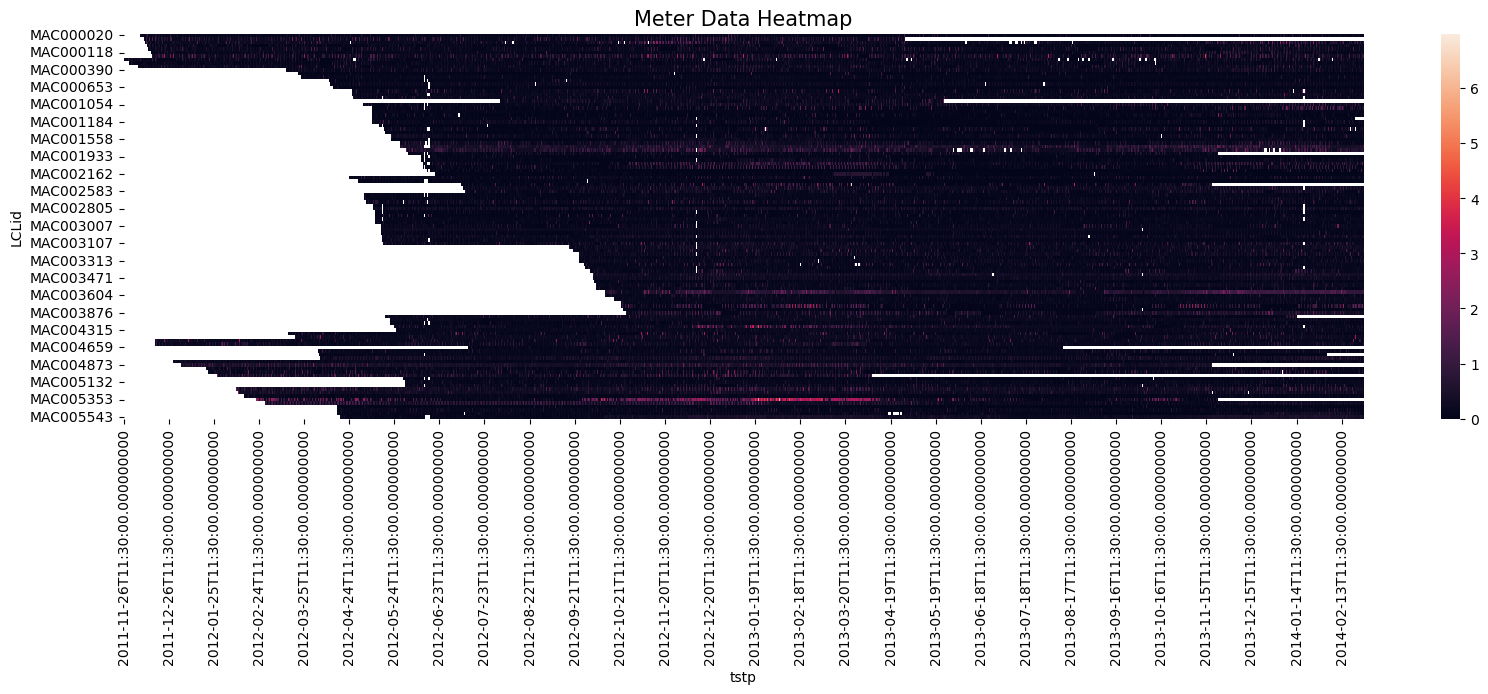

In [23]:
# visualize meter read coverage and completeness
# using a random sample of 2% of meters
import matplotlib.ticker as ticker
plt.subplots(figsize=(20,5))
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='kWhPerHalfHour')
sns.heatmap(pivot_table, xticklabels=48*30)
plt.title('Meter Data Heatmap', size=15)
plt.savefig('meter data heatmap.png', format='png')

In [24]:

'''
def to_datetime(x):
  return pd.to_datetime(x, format='%Y-%m-%d %H:%M')

def format_datetime(x):
  return x.strftime('%Y-%m-%d %H:%M')

# Create a pivot table of the data
# pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='kWhPerHalfHour')

# Convert the timestamps to datetime objects
pivot_table.columns = pivot_table.columns.map(to_datetime)

# Create a heatmap of the data
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(pivot_table, ax=ax, xticklabels=pivot_table.columns.map(format_datetime))

# Set the title and save the figure
plt.title('Meter Data Heatmap', size=15)
plt.savefig('meter data heatmap.png', format='png')
'''

"\ndef to_datetime(x):\n  return pd.to_datetime(x, format='%Y-%m-%d %H:%M')\n\ndef format_datetime(x):\n  return x.strftime('%Y-%m-%d %H:%M')\n\n# Create a pivot table of the data\n# pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='kWhPerHalfHour')\n\n# Convert the timestamps to datetime objects\npivot_table.columns = pivot_table.columns.map(to_datetime)\n\n# Create a heatmap of the data\nfig, ax = plt.subplots(figsize=(20, 5))\nsns.heatmap(pivot_table, ax=ax, xticklabels=pivot_table.columns.map(format_datetime))\n\n# Set the title and save the figure\nplt.title('Meter Data Heatmap', size=15)\nplt.savefig('meter data heatmap.png', format='png')\n"

## Identify and remove smart meter readings not exactly on the half-hour

In [25]:
# identify and remove records not exactly on the half-hour
start_time = time.time()

offRecs = d.query("tstp.dt.minute not in (0,30) or tstp.dt.second != 0")
# aggLoad["DateTime"].dt.hour > 30
print('\nRecords not exactly on the half-hour:\n ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
d.drop(offRecs.index, inplace=True)

print('%s seconds' % (time.time() - start_time))

offRecs = d.query("tstp.dt.minute not in (0,30) or tstp.dt.second != 0")
print('\nRecords not exactly on the half-hour:\n ', offRecs)


Records not exactly on the half-hour:
                 LCLid                tstp  kWhPerHalfHour
18051      MAC000047 2012-12-18 15:13:44             NaN
52485      MAC000362 2012-12-18 15:15:14             NaN
86881      MAC000385 2012-12-18 15:15:16             NaN
120772     MAC000486 2012-12-18 15:15:42             NaN
138889     MAC000507 2012-12-18 15:15:45             NaN
...              ...                 ...             ...
167658239  MAC005035 2012-12-18 15:14:33             NaN
167694593  MAC005048 2012-12-18 15:14:35             NaN
167730712  MAC005229 2012-12-18 15:14:41             NaN
167763454  MAC005448 2012-12-18 15:16:23             NaN
167796074  MAC005508 2012-12-18 15:16:29             NaN

[5560 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5560 entries, 18051 to 167796074
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   LCLid           5560 non-n

In [26]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167811461 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   tstp            datetime64[ns]
 2   kWhPerHalfHour  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.0+ GB


In [27]:
# check what is gobbling RAM
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             d: 14.1 GiB
                            __: 266.7 MiB
                        sample: 266.7 MiB
                           _22: 266.7 MiB
                   pivot_table: 33.5 MiB
                   weatherData:  5.5 MiB
                           ___: 992.3 KiB
               weatherUpsample: 992.3 KiB
                           _13: 992.3 KiB
                            _3:  1.3 KiB


## Fill gaps in the smart meter data

Our heatmap above shows lots of gaps (small white vertical lines), and we'll fill those gaps using interpolation

### First step of filling these gaps is to create NaN records where records are missing

Then we can fill these gaps with interpolation

In [28]:
# First step of interpolation is to create NaN records where records are missing
# about 2 minutes
d.sort_values(by=['tstp'], inplace=True)
d.set_index('tstp', inplace=True)
d.index.rename('tstp', inplace=True)

start_time = time.time()
# resample to create NaN records where records are missing
d = d.groupby('LCLid')\
                .resample('30Min')\
                .mean()

# fill the gaps with interpolation
d['kWhPerHalfHour'] = d['kWhPerHalfHour'].interpolate(limit=2, limit_area='inside')
d.reset_index(inplace=True)

print('%s seconds' % (time.time() - start_time))

96.11347675323486 seconds


## Check the meter data heatmap to see if gaps have been filled

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168268119 entries, 0 to 168268118
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   tstp            datetime64[ns]
 2   kWhPerHalfHour  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ GB


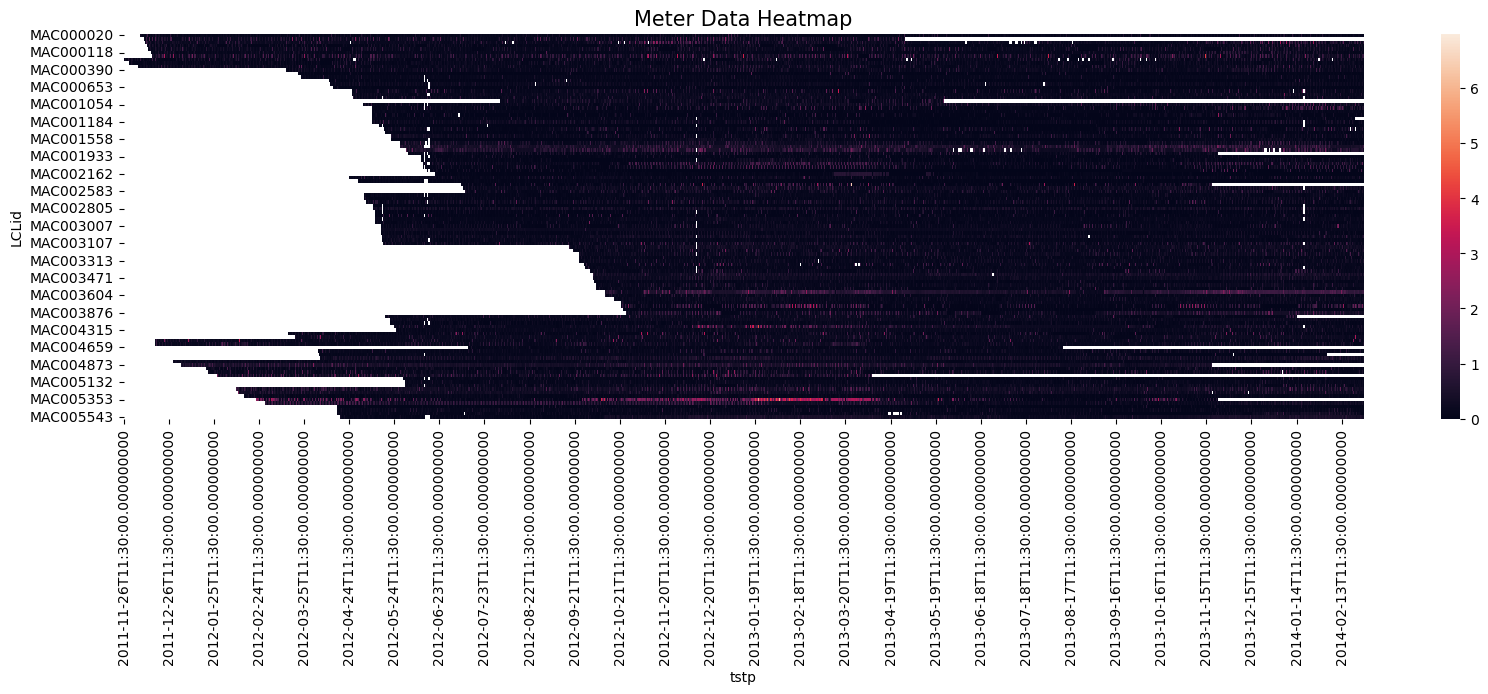

In [29]:
# visualize after interpolating missing values
d.info()
sample = d[d['LCLid'].isin(sampleMeters)]
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='kWhPerHalfHour')
plt.subplots(figsize=(20,5))
sns.heatmap(pivot_table, xticklabels=48*30) # one xtick label every month
plt.title('Meter Data Heatmap', size=15)
plt.savefig('meter data heatmap gaps filled.png', format='png')

## Visualize zeros in the dataset using heatmap

I'm always curious to understand zeros in a dataset, and whether they are legitimate zero values, or indicate a data quality problem.

5.522625923156738 seconds


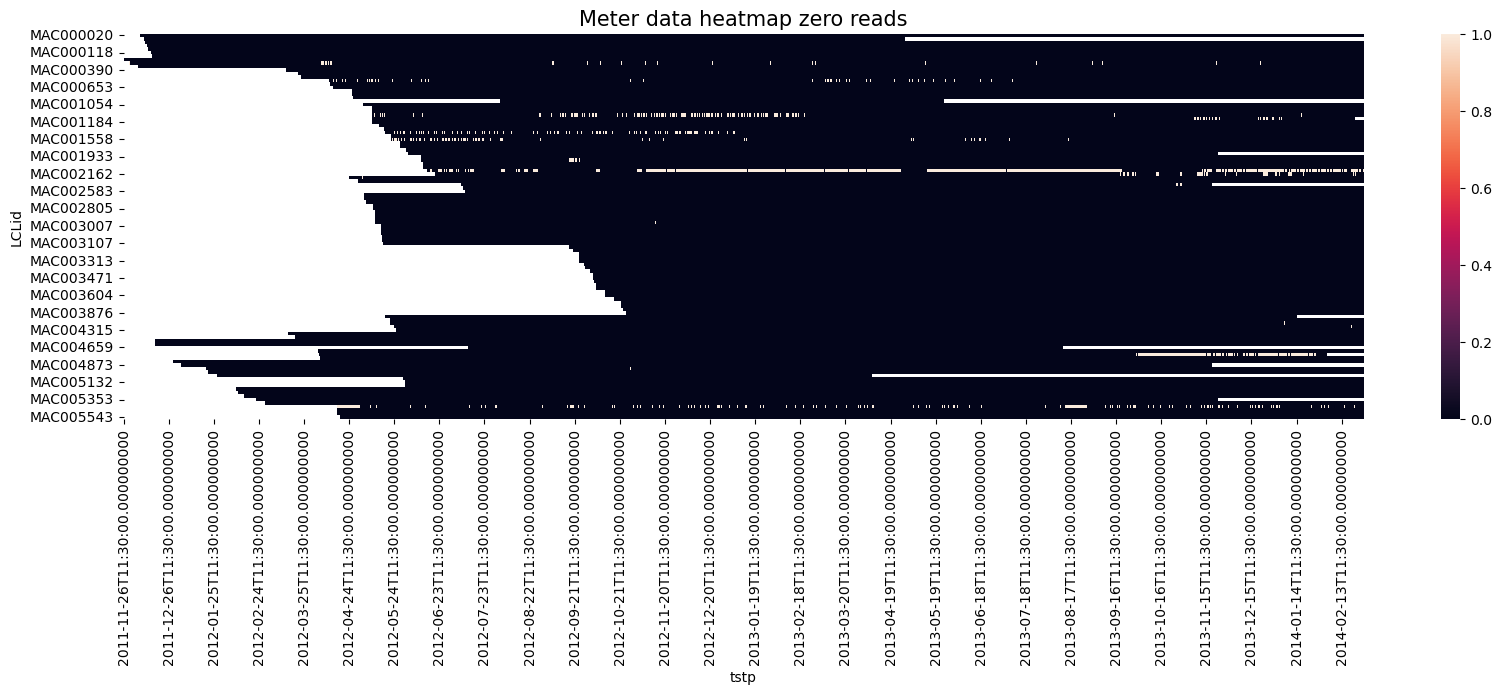

In [30]:
# visualize zeros in the dataset
start_time = time.time()
sample = d[d['LCLid'].isin(sampleMeters)]
sample['ZerokWhPerHalfHour'] = sample['kWhPerHalfHour'] == 0
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='ZerokWhPerHalfHour')
print('%s seconds' % (time.time() - start_time))
plt.subplots(figsize=(20,5))
sns.heatmap(pivot_table, xticklabels=48*30)
plt.title('Meter data heatmap zero reads', size=15)
plt.savefig('meter data heatmap zeros.png', format='png')

In [31]:
# take a snapshot of data
# takes about 11 minutes
start_time = time.time()
d.to_csv('/kaggle/working/MeterDataFinal.csv',index=False)
print('%s seconds' % (time.time() - start_time))

504.7215507030487 seconds


In [32]:
# gather the meters from the sample that have zero reads and count how many zero reads each has
sampleMetersWithZeroReads = sample[sample['kWhPerHalfHour'] == 0].groupby('LCLid').agg('count')
sampleMetersWithZeroReads

tstp  kWhPerHalfHour  ZerokWhPerHalfHour
LCLid                                               
MAC000133      5               5                   5
MAC000214    684             684                 684
MAC000390      4               4                   4
MAC000549   1181            1181                1181
MAC000653      1               1                   1
MAC001159      3               3                   3
MAC001170   3825            3825                3825
MAC001180    704             704                 704
MAC001413   2502            2502                2502
MAC001558   1943            1943                1943
MAC001933      5               5                   5
MAC001938    303             303                 303
MAC001982      1               1                   1
MAC002050  19774           19774               19774
MAC002162   2812            2812                2812
MAC002320     19              19                  19
MAC002510    135             135                 135
MAC002805      3               3                   3
MAC002866     23              23                  23
MAC003040      3               3                   3
MAC003085     11              11                  11
MAC003274      1               1                   1
MAC003486      4               4                   4
MAC003789      2               2                   2
MAC003837      4               4                   4
MAC004157      2               2                   2
MAC004190     88              88                  88
MAC004271     43              43                  43
MAC004460      1               1                   1
MAC004803   4939            4939                4939
MAC004927     14              14                  14
MAC005445   5315            5315                5315
MAC005543      4               4                   4

              LCLid                tstp  kWhPerHalfHour  ZerokWhPerHalfHour
64435506  MAC002050 2012-06-15 00:30:00             0.0                True
64435507  MAC002050 2012-06-15 01:00:00             0.0                True
64435508  MAC002050 2012-06-15 01:30:00             0.0                True
64435509  MAC002050 2012-06-15 02:00:00             0.0                True
64435510  MAC002050 2012-06-15 02:30:00             0.0                True
...             ...                 ...             ...                 ...
64465405  MAC002050 2014-02-27 22:00:00             0.0                True
64465406  MAC002050 2014-02-27 22:30:00             0.0                True
64465407  MAC002050 2014-02-27 23:00:00             0.0                True
64465408  MAC002050 2014-02-27 23:30:00             0.0                True
64465409  MAC002050 2014-02-28 00:00:00             0.0                True

[29904 rows x 4 columns]


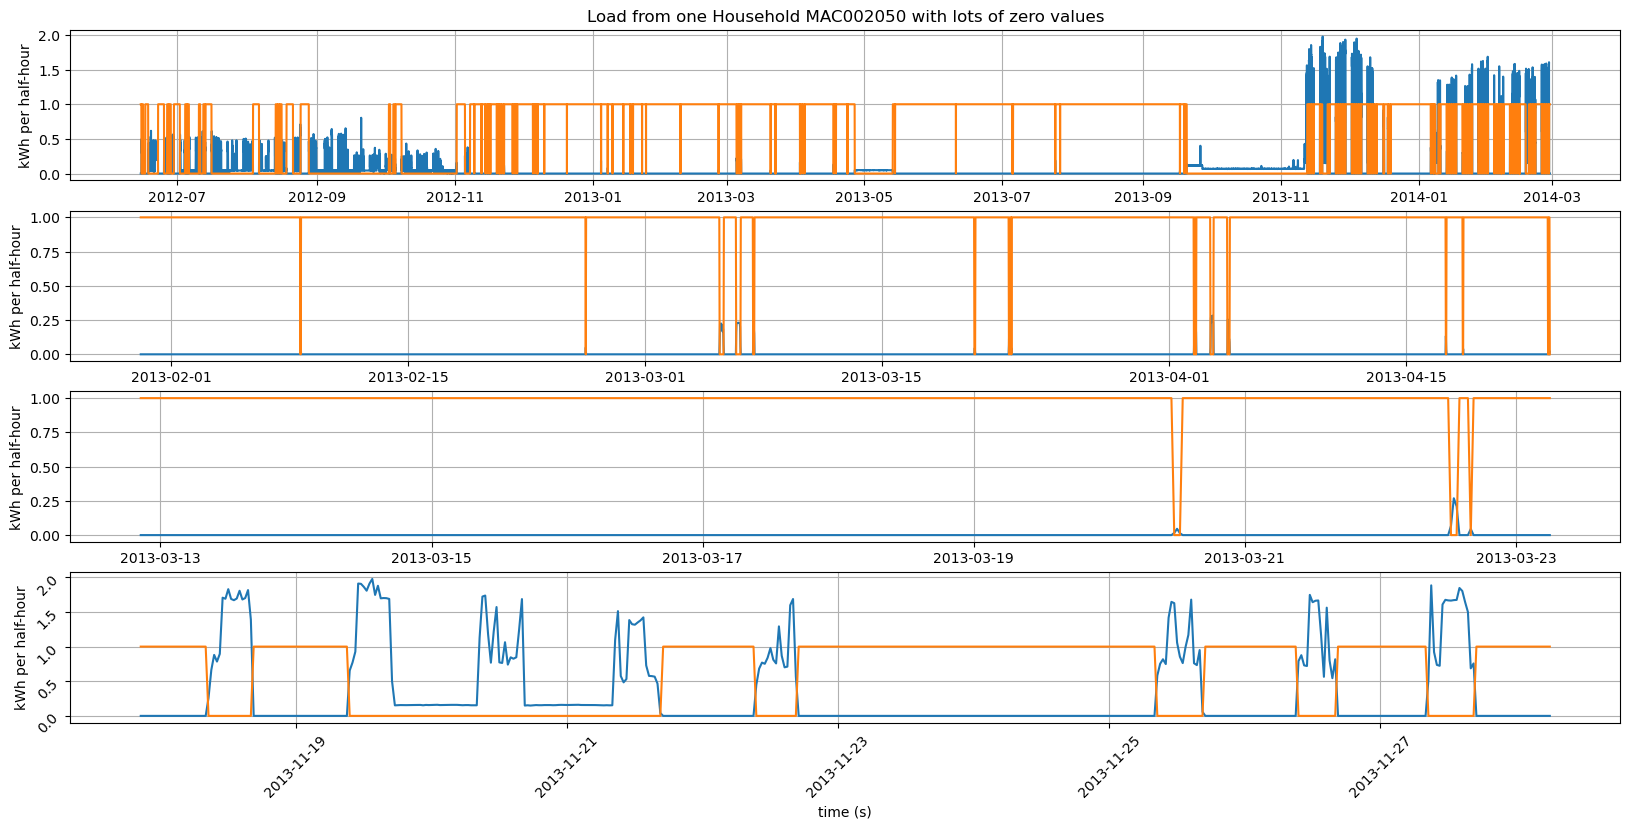

In [33]:
# investigate the meters with zero reads
MAC002050 = sample.query("LCLid == 'MAC002050'")
print(MAC002050)
fig, ax = plt.subplots(4,figsize=(20,9))

# plot whole ~2 years
ax[0].plot(MAC002050.tstp, MAC002050.kWhPerHalfHour)
ax[0].plot(MAC002050.tstp, MAC002050.ZerokWhPerHalfHour)
ax[0].set(ylabel='kWh per half-hour',
       title='Load from one Household MAC002050 with lots of zero values')
plt.tick_params(rotation=45)
ax[0].grid()

# zoom in
ax[1].plot(MAC002050.tstp[11000:15000], MAC002050.kWhPerHalfHour[11000:15000])
ax[1].plot(MAC002050.tstp[11000:15000], MAC002050.ZerokWhPerHalfHour[11000:15000])
ax[1].set(xlabel='time (s)', ylabel='kWh per half-hour')
plt.tick_params(rotation=45)
ax[1].grid()

# zoom in more...
ax[2].plot(MAC002050.tstp[13000:13500], MAC002050.kWhPerHalfHour[13000:13500])
ax[2].plot(MAC002050.tstp[13000:13500], MAC002050.ZerokWhPerHalfHour[13000:13500])
ax[2].set(xlabel='time (s)', ylabel='kWh per half-hour')
plt.tick_params(rotation=45)
ax[2].grid()

# zoom in to a different part of the series...
ax[3].plot(MAC002050.tstp[25000:25500], MAC002050.kWhPerHalfHour[25000:25500])
ax[3].plot(MAC002050.tstp[25000:25500], MAC002050.ZerokWhPerHalfHour[25000:25500])
ax[3].set(xlabel='time (s)', ylabel='kWh per half-hour')
plt.tick_params(rotation=45)
ax[3].grid()

fig.savefig("MAC002050.png")
plt.show()

Observation: The zeros for MAC002050 seem legit - leaving them in

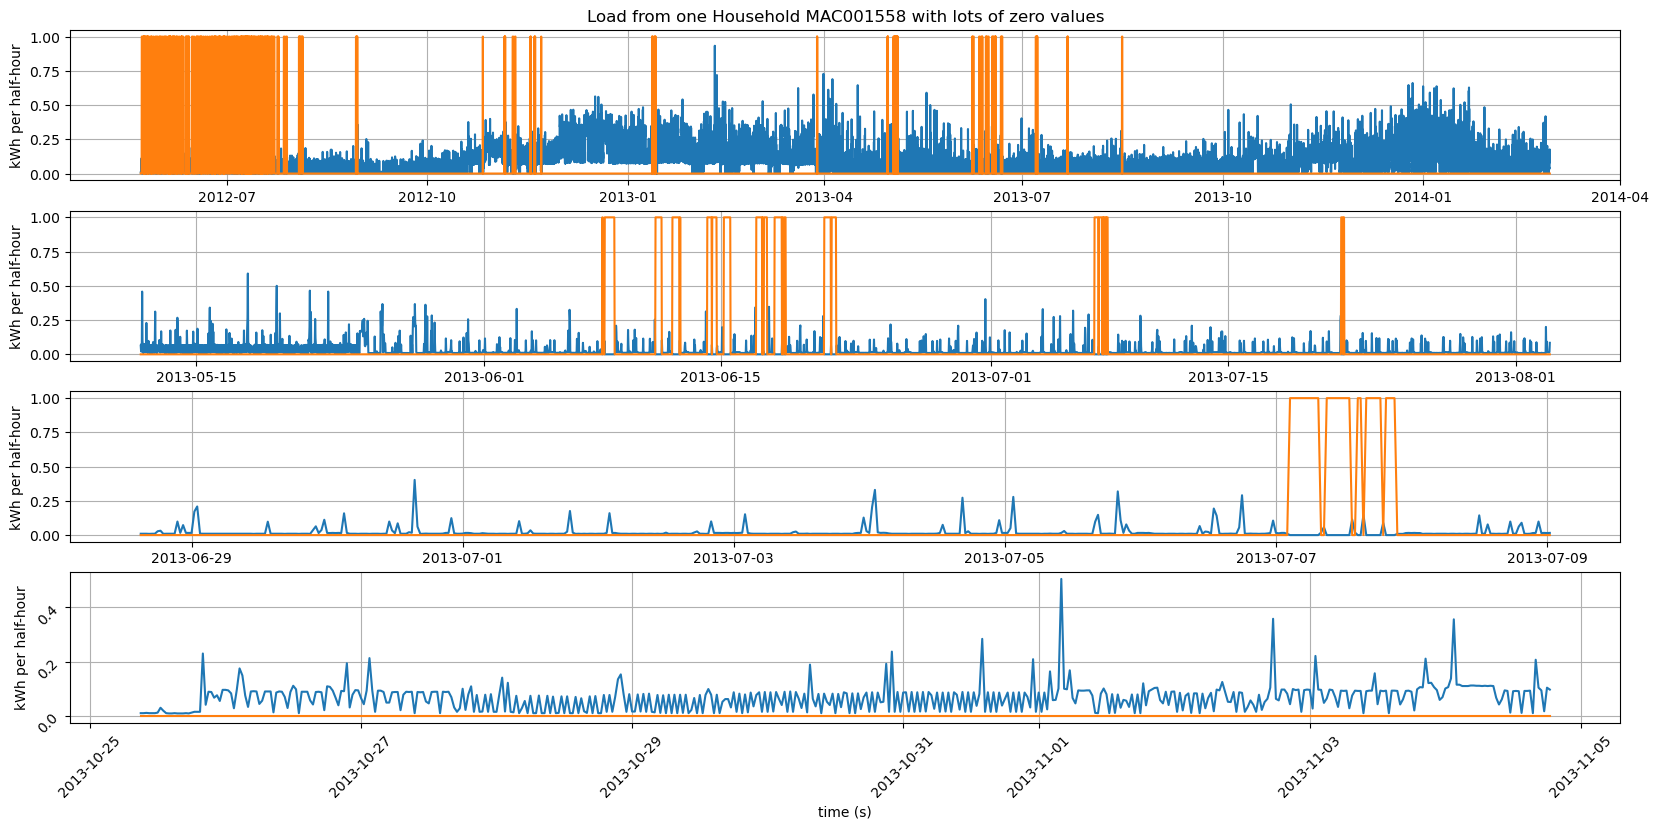

In [34]:
# investigate the meters with zero reads
MAC001558 = sample.query("LCLid == 'MAC001558'")
fig, ax = plt.subplots(4,figsize=(20,9))

# plot whole ~2 years
ax[0].plot(MAC001558.tstp, MAC001558.kWhPerHalfHour)
ax[0].plot(MAC001558.tstp, MAC001558.ZerokWhPerHalfHour)
ax[0].set(ylabel='kWh per half-hour',
       title='Load from one Household MAC001558 with lots of zero values')
plt.tick_params(rotation=45)
ax[0].grid()

# zoom in
ax[1].plot(MAC001558.tstp[17000:21000], MAC001558.kWhPerHalfHour[17000:21000])
ax[1].plot(MAC001558.tstp[17000:21000], MAC001558.ZerokWhPerHalfHour[17000:21000])
ax[1].set(xlabel='time (s)', ylabel='kWh per half-hour')
plt.tick_params(rotation=45)
ax[1].grid()

# zoom in more...
ax[2].plot(MAC001558.tstp[19300:19800], MAC001558.kWhPerHalfHour[19300:19800])
ax[2].plot(MAC001558.tstp[19300:19800], MAC001558.ZerokWhPerHalfHour[19300:19800])
ax[2].set(xlabel='time (s)', ylabel='kWh per half-hour')
plt.tick_params(rotation=45)
ax[2].grid()

# zoom in to a different part of the series...
ax[3].plot(MAC001558.tstp[25000:25500], MAC001558.kWhPerHalfHour[25000:25500])
ax[3].plot(MAC001558.tstp[25000:25500], MAC001558.ZerokWhPerHalfHour[25000:25500])
ax[3].set(xlabel='time (s)', ylabel='kWh per half-hour')
plt.tick_params(rotation=45)
ax[3].grid()

fig.savefig("MAC001558.png")
plt.show()

Observation: The zeros for MAC001558 seem legit - leaving them in

In [35]:
# explore some basic stats for each house
print(d.groupby('LCLid').max().sort_values('tstp'))
print(d.groupby('LCLid').min().sort_values('tstp'))
print(d.groupby('LCLid').count().sort_values('tstp'))

print(d.groupby('LCLid').agg(['min', 'max', 'count']))


                         tstp  kWhPerHalfHour
LCLid                                        
MAC001300 2012-05-22 23:30:00           1.697
MAC001278 2012-05-24 23:30:00           1.168
MAC005565 2012-06-21 07:00:00           1.022
MAC001957 2012-06-26 00:00:00           0.940
MAC002110 2012-06-26 10:00:00           0.919
...                       ...             ...
MAC001976 2014-02-28 00:00:00           2.751
MAC001975 2014-02-28 00:00:00           2.096
MAC001974 2014-02-28 00:00:00           2.623
MAC001993 2014-02-28 00:00:00           1.347
MAC005567 2014-02-28 00:00:00           1.528

[5561 rows x 2 columns]
                         tstp  kWhPerHalfHour
LCLid                                        
MAC000145 2011-11-23 09:00:00           0.024
MAC000146 2011-11-23 09:00:00           0.031
MAC000147 2011-11-23 10:00:00           0.008
MAC000148 2011-11-23 10:00:00           0.000
MAC000149 2011-11-23 10:00:00           0.000
...                       ...             ...
MAC003155

In [36]:
# set index for the sample
sample.set_index('tstp')

LCLid  kWhPerHalfHour  ZerokWhPerHalfHour
tstp                                                              
2011-12-07 09:30:00  MAC000020           0.275               False
2011-12-07 10:00:00  MAC000020           0.231               False
2011-12-07 10:30:00  MAC000020           0.204               False
2011-12-07 11:00:00  MAC000020           0.194               False
2011-12-07 11:30:00  MAC000020           0.317               False
...                        ...             ...                 ...
2014-02-27 22:00:00  MAC005543           0.465               False
2014-02-27 22:30:00  MAC005543           0.464               False
2014-02-27 23:00:00  MAC005543           0.459               False
2014-02-27 23:30:00  MAC005543           0.425               False
2014-02-28 00:00:00  MAC005543           0.373               False

[3418426 rows x 3 columns]

## EDA: Visualize daily average load for each meter and all meters...

19.36050295829773 seconds
28.593847036361694 seconds


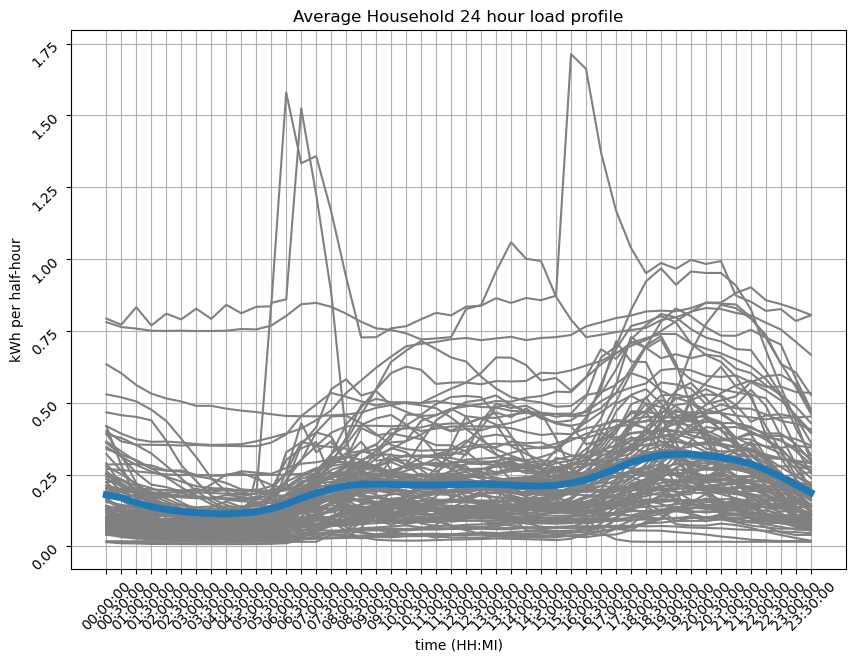

In [37]:
# calculate average daily load profile for all meters...
# about 1.5 minutes

start_time = time.time()
avgLoadProfile = pd.DataFrame(d.groupby([d['tstp'].dt.hour, d['tstp'].dt.minute]).kWhPerHalfHour.mean())
avgLoadProfile = avgLoadProfile.reset_index(names=['hour', 'minute'])
avgLoadProfile['labels'] = pd.to_datetime(avgLoadProfile['hour'].astype(str) + ':' + avgLoadProfile['minute'].astype(str), format='%H:%M').dt.time
print('%s seconds' % (time.time() - start_time))

fig, ax = plt.subplots(figsize=(10,7))

ax.set_xticks(avgLoadProfile.index, avgLoadProfile.labels)

ax.set(xlabel='time (HH:MI)', ylabel='kWh per half-hour',
       title='Average Household 24 hour load profile')

# calculate average daily load for each meter...
start_time = time.time()
avgLoadProfileEachMeter = pd.DataFrame(d.groupby(['LCLid', d['tstp'].dt.hour, d['tstp'].dt.minute]).agg({'kWhPerHalfHour': 'mean'}))
avgLoadProfileEachMeter = avgLoadProfileEachMeter.reset_index(names=['LCLid', 'hour', 'minute'])
print('%s seconds' % (time.time() - start_time))
# print(avgLoadProfileEachMeter.info())
# print(avgLoadProfileEachMeter)

# plot every sample meter
for meter in sampleMeters:
    # print(meter)
    ax.plot(avgLoadProfileEachMeter.loc[avgLoadProfileEachMeter['LCLid'] == meter].index % 48, 
            avgLoadProfileEachMeter.loc[avgLoadProfileEachMeter['LCLid'] == meter].kWhPerHalfHour,
           color='grey')

# plot the average
ax.plot(avgLoadProfile.index, avgLoadProfile.kWhPerHalfHour, linewidth=5)

plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Avg 24hr Load Profile every meter.png")
plt.show()

## Create aggregate features: aggregate load (our target) and count of meters

In [38]:
# Calculate the sum of all loads and count of smart meters for each timestamp
start_time = time.time()
aggLoad = pd.DataFrame(d.groupby('tstp')['kWhPerHalfHour'].agg({'sum', 'count'}))
aggLoad.reset_index(inplace=True)
aggLoad.columns = ['tstp', 'AggregateLoad', 'numMeters']
print('%s seconds' % (time.time() - start_time))

print(aggLoad)
print(aggLoad.describe())
print(aggLoad.info())

4.520201921463013 seconds
                     tstp  AggregateLoad  numMeters
0     2011-11-23 09:00:00       0.569000          2
1     2011-11-23 09:30:00       0.561000          2
2     2011-11-23 10:00:00       0.920000          6
3     2011-11-23 10:30:00       0.588000          6
4     2011-11-23 11:00:00       0.772000          7
...                   ...            ...        ...
39722 2014-02-27 22:00:00    1494.829500       4987
39723 2014-02-27 22:30:00    1422.109001       4987
39724 2014-02-27 23:00:00    1258.090000       4987
39725 2014-02-27 23:30:00    1073.622001       4987
39726 2014-02-28 00:00:00    1042.266000       4987

[39727 rows x 3 columns]
       AggregateLoad     numMeters
count   39727.000000  39727.000000
mean      894.773908   4224.970448
std       518.014522   1789.290602
min         0.561000      2.000000
25%       531.521500   4082.000000
50%       874.585999   5127.000000
75%      1220.344500   5361.000000
max      2607.331610   5532.000000
<class 'p

In [39]:
aggLoad.sort_values(by=['tstp'], inplace=True)
aggLoad.set_index('tstp', inplace=True)
aggLoad.index.rename('DateTimeIndex', inplace=True)
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AggregateLoad  39727 non-null  float64
 1   numMeters      39727 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 931.1 KB


In [40]:
aggLoad['DateTime'] = aggLoad.index
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  39727 non-null  float64       
 1   numMeters      39727 non-null  int64         
 2   DateTime       39727 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.2 MB


In [41]:
# identify records with zero load
# start with the aggregated records with zero load
AggZeros = aggLoad.query("AggregateLoad == 0")
AggZeros

Empty DataFrame
Columns: [AggregateLoad, numMeters, DateTime]
Index: []

In [42]:
# inspect and fix records not exactly on the half-hour
offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
aggLoad = aggLoad.drop(offRecs.index)

offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

Records not exactly on the half-hour:  Empty DataFrame
Columns: [AggregateLoad, numMeters, DateTime]
Index: []
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  0 non-null      float64       
 1   numMeters      0 non-null      int64         
 2   DateTime       0 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 0.0 bytes
None
Records not exactly on the half-hour:  Empty DataFrame
Columns: [AggregateLoad, numMeters, DateTime]
Index: []


In [43]:
# check the regularity of the observations (time between observations)
# print(pd.infer_freq(train_data.DateTime))
aggLoad.index.to_series().diff().value_counts()

0 days 00:30:00    39726
Name: DateTimeIndex, dtype: int64

In [44]:
# Calculate moving average and stddev for the aggregated load across all meters
window_size = int(len(aggLoad.AggregateLoad) / 10)
print(window_size)

aggLoadMovingStdev = aggLoad.AggregateLoad.rolling(window_size).std()
aggLoadMovingStdev.columns = ['MovingStdev']

aggLoadMovingAvg = aggLoad.AggregateLoad.rolling(window_size).mean()
aggLoadMovingAvg.columns = ['MovingAvg']

print('aggLoadMovingStdev:\n', aggLoadMovingStdev)
print(aggLoadMovingStdev.info())
print('aggLoadMovingAvg:\n', aggLoadMovingAvg)
print(aggLoadMovingAvg.info())

3972
aggLoadMovingStdev:
 DateTimeIndex
2011-11-23 09:00:00           NaN
2011-11-23 09:30:00           NaN
2011-11-23 10:00:00           NaN
2011-11-23 10:30:00           NaN
2011-11-23 11:00:00           NaN
                          ...    
2014-02-27 22:00:00    400.030212
2014-02-27 22:30:00    399.940348
2014-02-27 23:00:00    399.840222
2014-02-27 23:30:00    399.756903
2014-02-28 00:00:00    399.684227
Name: AggregateLoad, Length: 39727, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
35756 non-null  float64
dtypes: float64(1)
memory usage: 620.7 KB
None
aggLoadMovingAvg:
 DateTimeIndex
2011-11-23 09:00:00            NaN
2011-11-23 09:30:00            NaN
2011-11-23 10:00:00            NaN
2011-11-23 10:30:00            NaN
2011-11-23 11:00:00            NaN
                          ...     
2014-02-27 22:00:00    1212.982211
20

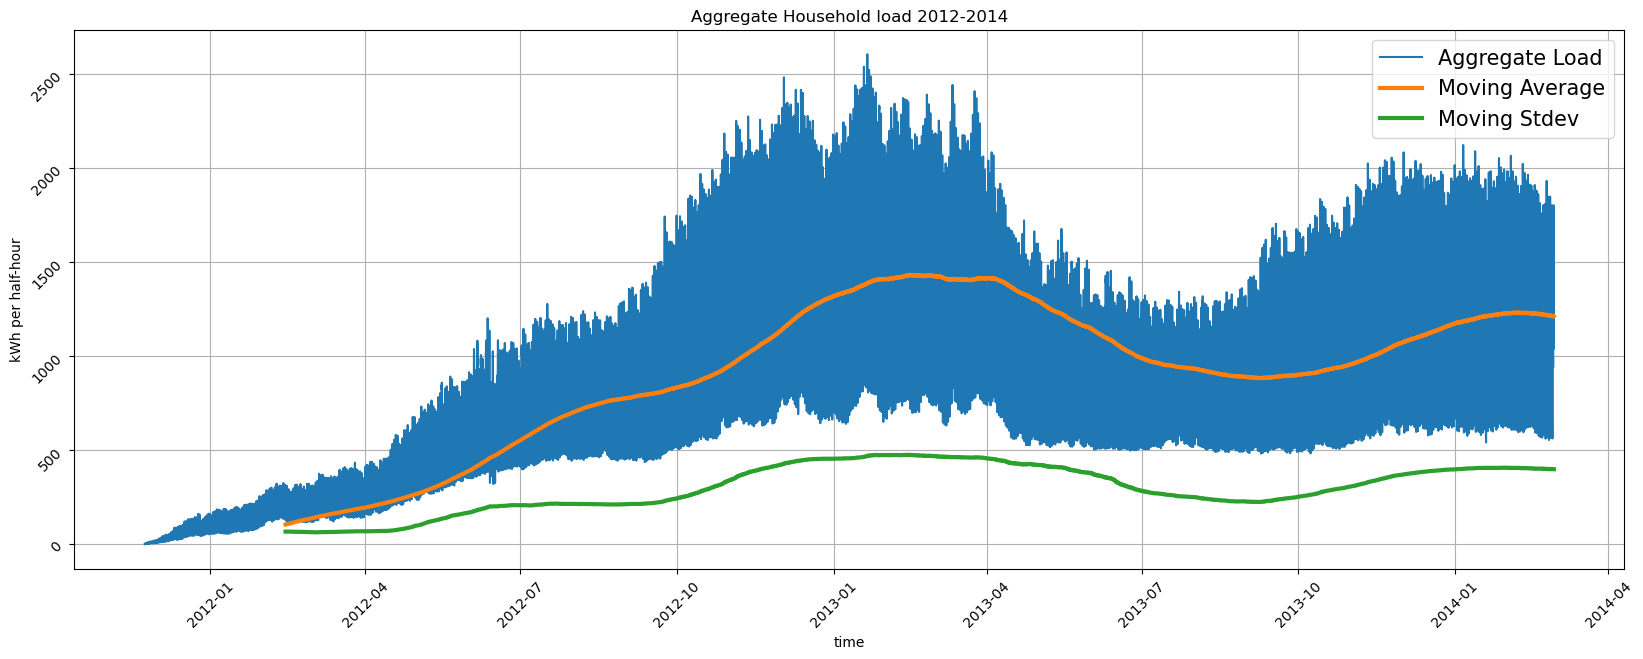

In [45]:
# Visualize aggregate load, moving average, moving standard deviation
# print(aggLoad)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime, aggLoad.AggregateLoad, label="Aggregate Load")
ax.plot(aggLoad.DateTime, aggLoadMovingAvg, linewidth=3, label="Moving Average")
ax.plot(aggLoad.DateTime, aggLoadMovingStdev, linewidth=3, label="Moving Stdev")

ax.set(xlabel='time', ylabel='kWh per half-hour',
       title='Aggregate Household load 2012-2014',)
plt.tick_params(rotation=45)
ax.grid()

plt.legend(fontsize=15)
fig.savefig("Aggregate Household load 2012-2014.png")
plt.show()

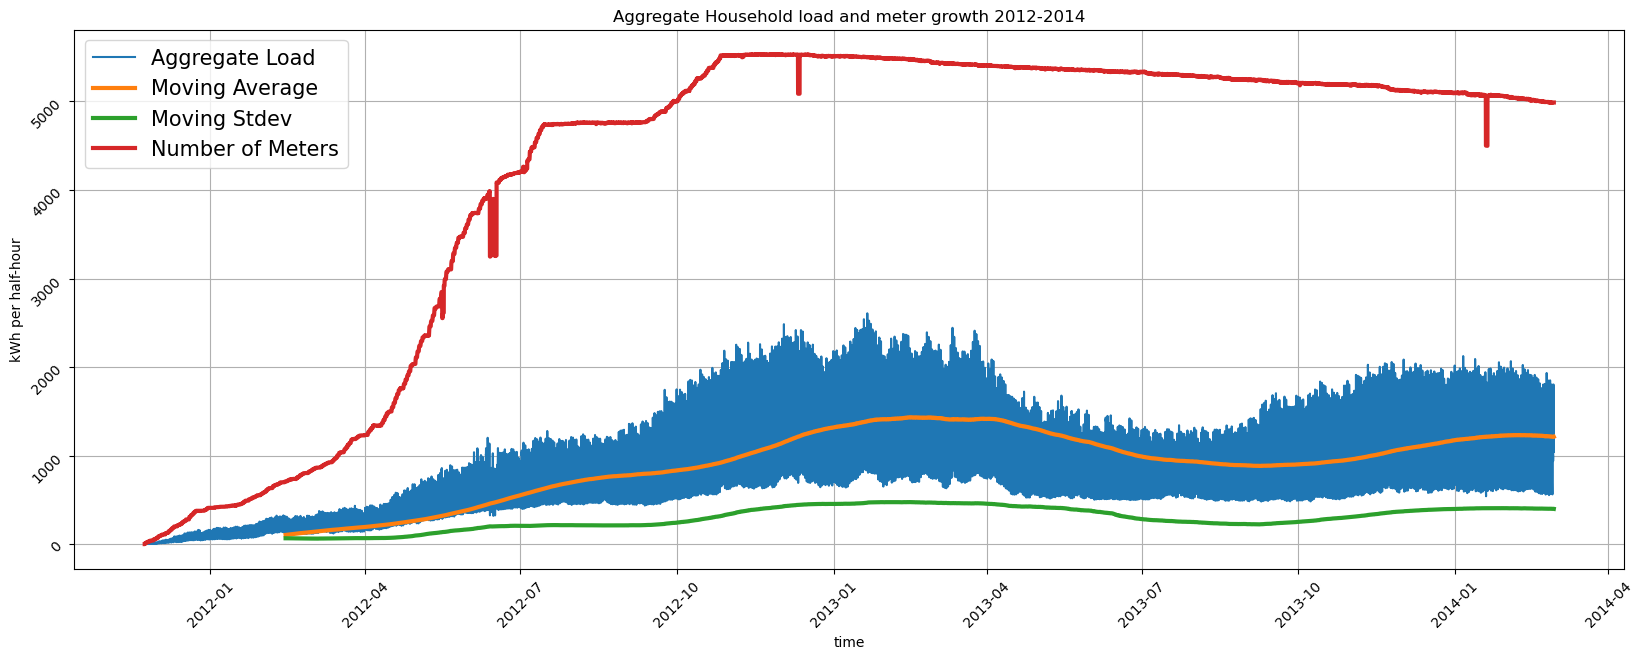

In [46]:
# Add number of meters to aggregate load, moving average, moving standard deviation
# This shows correlation of increased load with meters being added to the program during the recruitment period 
# print(aggLoad)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime, aggLoad.AggregateLoad, label="Aggregate Load")
ax.plot(aggLoad.DateTime, aggLoadMovingAvg, linewidth=3, label="Moving Average")
ax.plot(aggLoad.DateTime, aggLoadMovingStdev, linewidth=3, label="Moving Stdev")
ax.plot(aggLoad.DateTime, aggLoad.numMeters, linewidth=3, label="Number of Meters")

ax.set(xlabel='time', ylabel='kWh per half-hour',
       title='Aggregate Household load and meter growth 2012-2014')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load and meter growth 2012-2014.png")
plt.legend(fontsize=15)
plt.show()

## Explore our aggregate load curve at various scales

Zoom in gradually to a single day

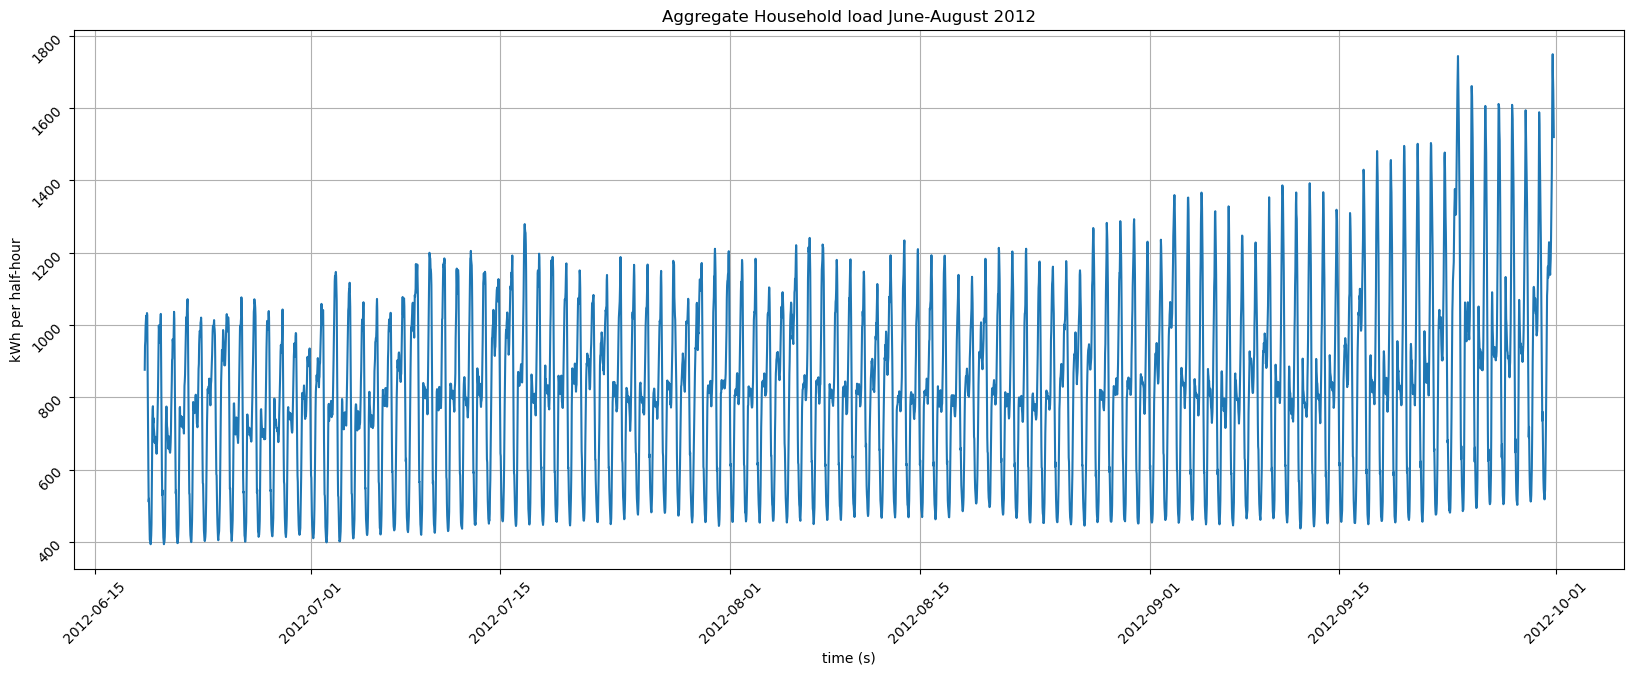

In [47]:
# Aggregate Household load June-August
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[10000:15000], aggLoad.AggregateLoad[10000:15000])

ax.set(xlabel='time (s)', ylabel='kWh per half-hour',
       title='Aggregate Household load June-August 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load June-August 2012.png")
plt.show()

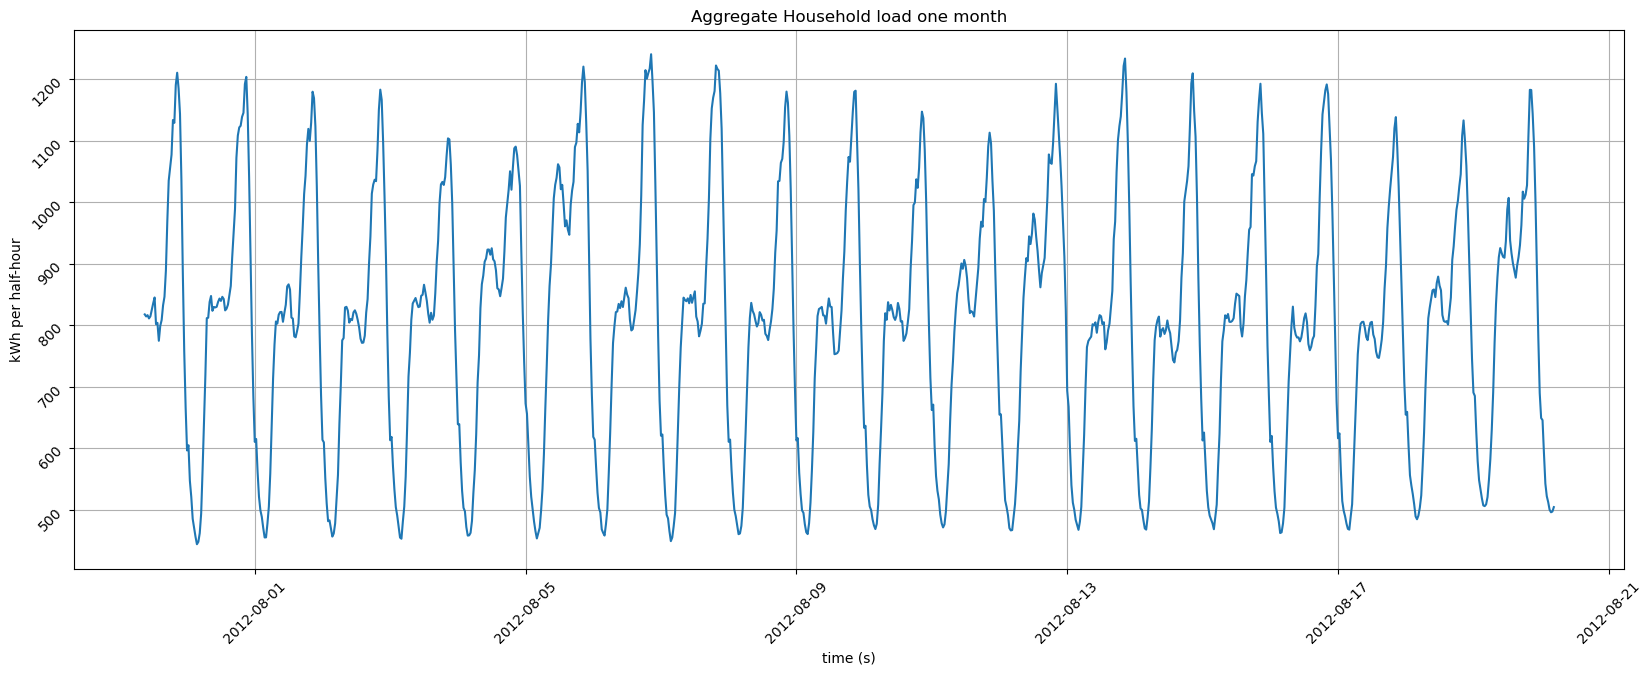

In [48]:
# Aggregate Household load one month
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[12000:13000], aggLoad.AggregateLoad[12000:13000])

ax.set(xlabel='time (s)', ylabel='kWh per half-hour',
       title='Aggregate Household load one month')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load one month.png")
plt.show()

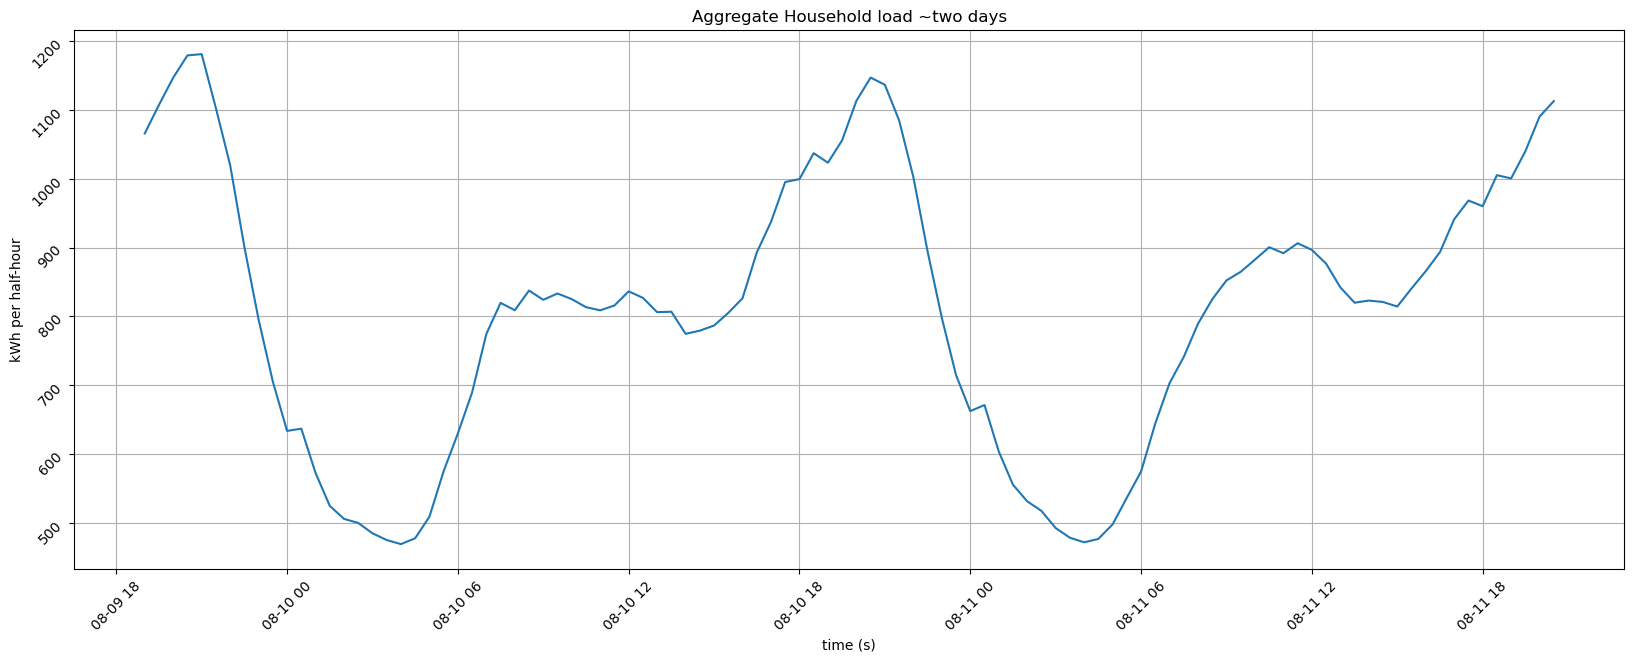

In [49]:
# Aggregate Household load ~two days
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[12500:12600], aggLoad.AggregateLoad[12500:12600])

ax.set(xlabel='time (s)', ylabel='kWh per half-hour',
       title='Aggregate Household load ~two days')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load two days.png")
plt.show()

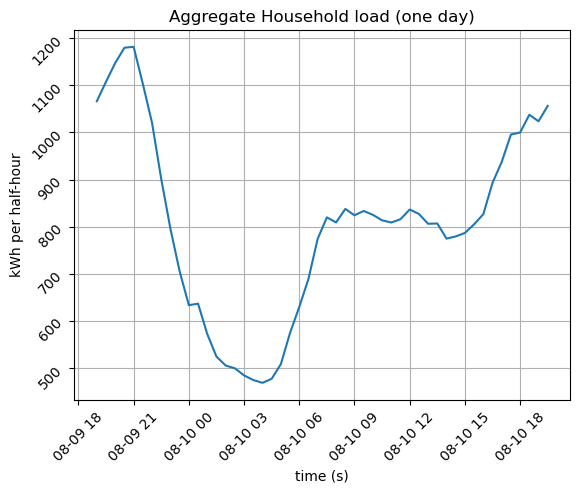

In [50]:
# Aggregate Household load (one day)
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[12500:12550], aggLoad.AggregateLoad[12500:12550])

ax.set(xlabel='time (s)', ylabel='kWh per half-hour',
       title='Aggregate Household load (one day)')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load (one day).png")
plt.show()

In [51]:
aggLoad.to_csv('/kaggle/working/aggLoadDataFinal.csv',index=False)

In [52]:
aggLoad = pd.read_csv('/kaggle/working/aggLoadDataFinal.csv', parse_dates=["DateTime"])
aggLoad

AggregateLoad  numMeters            DateTime
0           0.569000          2 2011-11-23 09:00:00
1           0.561000          2 2011-11-23 09:30:00
2           0.920000          6 2011-11-23 10:00:00
3           0.588000          6 2011-11-23 10:30:00
4           0.772000          7 2011-11-23 11:00:00
...              ...        ...                 ...
39722    1494.829500       4987 2014-02-27 22:00:00
39723    1422.109001       4987 2014-02-27 22:30:00
39724    1258.090000       4987 2014-02-27 23:00:00
39725    1073.622001       4987 2014-02-27 23:30:00
39726    1042.266000       4987 2014-02-28 00:00:00

[39727 rows x 3 columns]

In [53]:
aggLoad.iloc[35299]

AggregateLoad               1834.417
numMeters                       5125
DateTime         2013-11-27 18:30:00
Name: 35299, dtype: object

In [54]:
# Join load data and weather data
mergeData = pd.merge(aggLoad, weatherUpsample, on='DateTime', copy=False)
print(mergeData.info())
mergeData

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39727 entries, 0 to 39726
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  39727 non-null  float64       
 1   numMeters      39727 non-null  int64         
 2   DateTime       39727 non-null  datetime64[ns]
 3   temperature    39727 non-null  float64       
 4   dewPoint       39727 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 1.8 MB
None


AggregateLoad  numMeters            DateTime  temperature  dewPoint
0           0.569000          2 2011-11-23 09:00:00        4.840     4.680
1           0.561000          2 2011-11-23 09:30:00        5.290     5.070
2           0.920000          6 2011-11-23 10:00:00        5.740     5.460
3           0.588000          6 2011-11-23 10:30:00        6.705     5.600
4           0.772000          7 2011-11-23 11:00:00        7.670     5.740
...              ...        ...                 ...          ...       ...
39722    1494.829500       4987 2014-02-27 22:00:00        4.100     1.640
39723    1422.109001       4987 2014-02-27 22:30:00        4.015     1.625
39724    1258.090000       4987 2014-02-27 23:00:00        3.930     1.610
39725    1073.622001       4987 2014-02-27 23:30:00        3.870     1.570
39726    1042.266000       4987 2014-02-28 00:00:00        3.810     1.530

[39727 rows x 5 columns]

## Plot autocorrelation of aggregate load (target)

...to investigate cyclical properties

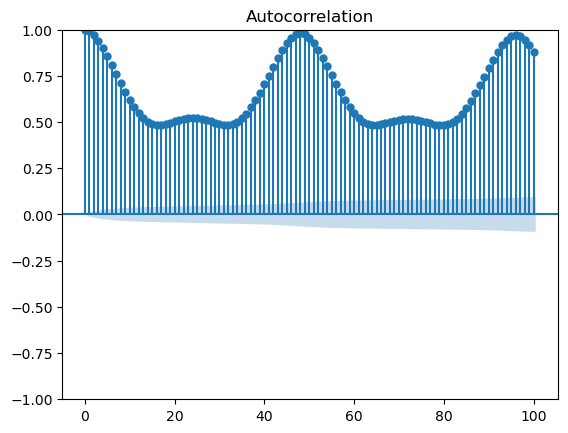

In [55]:
from statsmodels.graphics.tsaplots import plot_acf

# Extract the AggregateLoad feature
aggregate_load = mergeData['AggregateLoad']

# Plot the autocorrelation plot
plot_acf(aggregate_load, lags=100)

# Show the plot
plt.show()

# Feature engineering

## Cyclical features

In [56]:
# Add features useful for time series
print(mergeData.info())
# Cyclical features
# week of year
weekOfYear = mergeData.DateTime.dt.weekofyear
mergeData["weekOfYear_sin"] = np.sin(weekOfYear*(2.*np.pi/52))
mergeData["weekOfYear_cos"] = np.cos(weekOfYear*(2.*np.pi/52))
# day of week
dayOfWeek = mergeData.DateTime.dt.dayofweek
mergeData["dayOfWeek_sin"] = np.sin(dayOfWeek*(2.*np.pi/7))
mergeData["dayOfWeek_cos"] = np.cos(dayOfWeek*(2.*np.pi/7))
# day of year
# aggLoad["dayOfYear"] = aggLoad.DateTime.dt.dayofyear
# minute of the day
minuteOfDay = (mergeData.DateTime.dt.hour * 60) + mergeData.DateTime.dt.minute
mergeData["minuteOfDay_sin"] = np.sin(minuteOfDay*(2.*np.pi/48))
mergeData["minuteOfDay_cos"] = np.cos(minuteOfDay*(2.*np.pi/48))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39727 entries, 0 to 39726
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  39727 non-null  float64       
 1   numMeters      39727 non-null  int64         
 2   DateTime       39727 non-null  datetime64[ns]
 3   temperature    39727 non-null  float64       
 4   dewPoint       39727 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 1.8 MB
None


## Decomposition features

In [57]:
decomp_df = pd.DataFrame(mergeData.copy())
decomp_df = decomp_df.set_index(pd.DatetimeIndex(decomp_df['DateTime']))
decomp_df.index=decomp_df.DateTime
decomp_df = decomp_df.AggregateLoad
print(decomp_df.describe())
print(decomp_df.info)

count    39727.000000
mean       894.773908
std        518.014522
min          0.561000
25%        531.521500
50%        874.585999
75%       1220.344500
max       2607.331610
Name: AggregateLoad, dtype: float64
<bound method Series.info of DateTime
2011-11-23 09:00:00       0.569000
2011-11-23 09:30:00       0.561000
2011-11-23 10:00:00       0.920000
2011-11-23 10:30:00       0.588000
2011-11-23 11:00:00       0.772000
                          ...     
2014-02-27 22:00:00    1494.829500
2014-02-27 22:30:00    1422.109001
2014-02-27 23:00:00    1258.090000
2014-02-27 23:30:00    1073.622001
2014-02-28 00:00:00    1042.266000
Name: AggregateLoad, Length: 39727, dtype: float64>


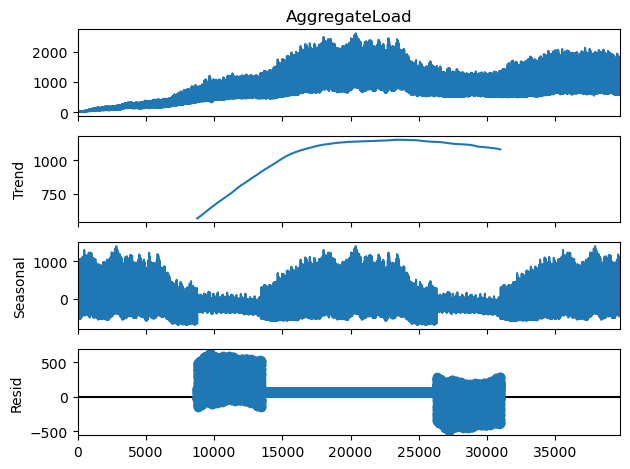

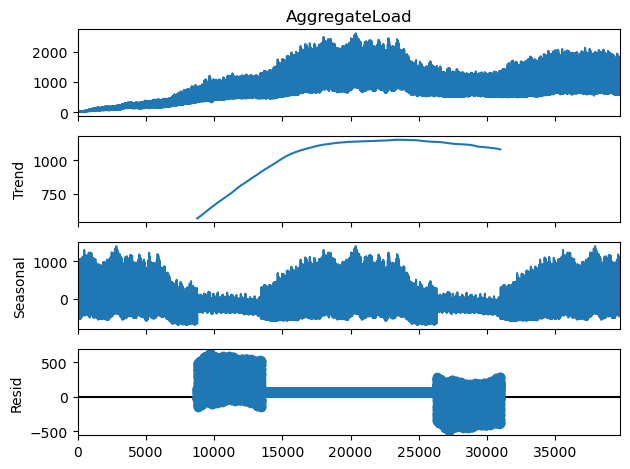

In [58]:
# Annual decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
yearly_seasonal_decomp = seasonal_decompose(mergeData['AggregateLoad'], period=17532)
mergeData['yearlySeasonal']=yearly_seasonal_decomp.seasonal
yearly_seasonal_decomp.plot()

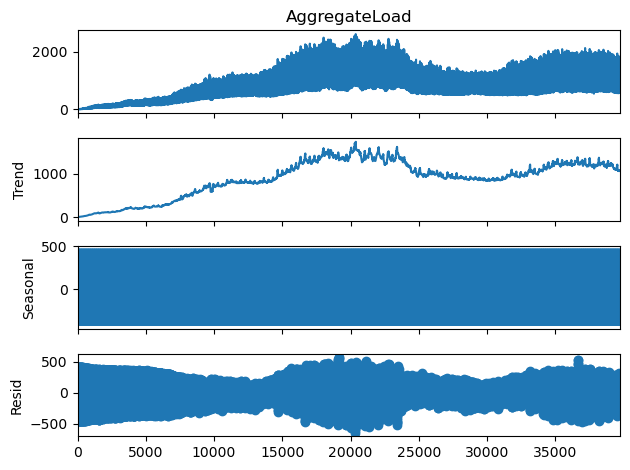

In [59]:
# daily decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
daily_seasonal_decomp = seasonal_decompose(mergeData['AggregateLoad'], period=48)
mergeData['dailyTrend']=daily_seasonal_decomp.trend
mergeData['dailySeasonal']=daily_seasonal_decomp.seasonal
mergeData['dailyResid']=daily_seasonal_decomp.resid
daily_seasonal_decomp.plot();

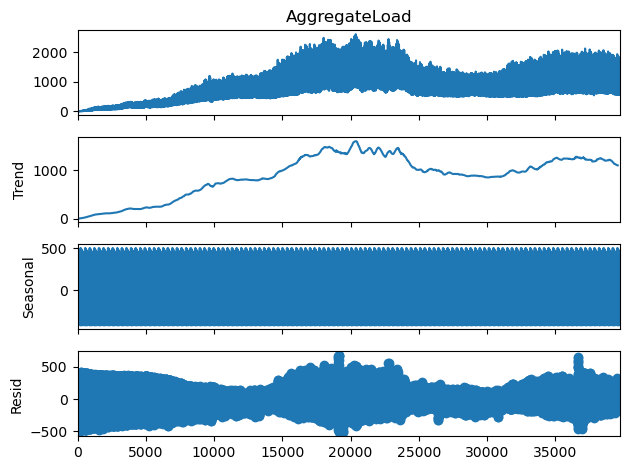

In [60]:
# weekly decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
weekly_seasonal_decomp = seasonal_decompose(mergeData['AggregateLoad'], period=336)
mergeData['weeklyTrend']=weekly_seasonal_decomp.trend
mergeData['weeklySeasonal']=weekly_seasonal_decomp.seasonal
mergeData['weeklyResid']=weekly_seasonal_decomp.resid
weekly_seasonal_decomp.plot();

## Lag features

In [61]:
# load 1 day lag
oneDayPeriods = 48
mergeData['AggregateLoad_1dayLag'] = mergeData['AggregateLoad'].shift(oneDayPeriods)
# load 1 week lag
oneWeekPeriods = oneDayPeriods * 7
mergeData['AggregateLoad_1weekLag'] = mergeData['AggregateLoad'].shift(oneWeekPeriods)

# load change from last half-hour to this half-hour
mergeData['AggregateLoad_halfhourdiff'] = mergeData['AggregateLoad'] - mergeData['AggregateLoad'].shift(1)
# load change from one week ago to this half-hour
mergeData['AggregateLoad_weekdiff'] = mergeData['AggregateLoad'] - mergeData['AggregateLoad'].shift(oneWeekPeriods)

print(mergeData.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39727 entries, 0 to 39726
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   AggregateLoad               39727 non-null  float64       
 1   numMeters                   39727 non-null  int64         
 2   DateTime                    39727 non-null  datetime64[ns]
 3   temperature                 39727 non-null  float64       
 4   dewPoint                    39727 non-null  float64       
 5   weekOfYear_sin              39727 non-null  float64       
 6   weekOfYear_cos              39727 non-null  float64       
 7   dayOfWeek_sin               39727 non-null  float64       
 8   dayOfWeek_cos               39727 non-null  float64       
 9   minuteOfDay_sin             39727 non-null  float64       
 10  minuteOfDay_cos             39727 non-null  float64       
 11  yearlySeasonal              39727 non-null  float64   

In [62]:
# drop NaNs created by feature engineering
mergeData.dropna(inplace=True)

In [63]:
# temperature change from last half-hour to this half-hour
# eliminated due to permutation feature importance
# weatherUpsample['temp_halfhourdiff'] = weatherUpsample['temperature'] - weatherUpsample['temperature'].shift(1)

# max temp for the day
mergeData['temp_daymax'] = mergeData.groupby(mergeData.DateTime.dt.date)['temperature'].transform('max')
mergeData['temp_daymin'] = mergeData.groupby(weatherUpsample.DateTime.dt.date)['temperature'].transform('min')
print(mergeData['temp_daymax'])
print(mergeData['temp_daymin'])

336      11.87
337      11.87
338      11.87
339      11.87
340      11.87
         ...  
39554    13.07
39555    13.07
39556    13.07
39557    13.07
39558    13.07
Name: temp_daymax, Length: 39223, dtype: float64
336      7.66
337      7.66
338      7.66
339      7.66
340      7.66
         ... 
39554    9.22
39555    9.22
39556    9.22
39557    9.22
39558    9.22
Name: temp_daymin, Length: 39223, dtype: float64


In [64]:
"""
# Find the earliest date when there is the maximum number of meters contributing to the aggregate load
# will disreard all data beofre this point
maxMeters = aggLoad['numMeters'].max()
print(maxMeters)
startDateTime = aggLoad[aggLoad['numMeters']==maxMeters].DateTime.min()
print(startDateTime)
startDate = startDateTime.date()
print(startDate)
"""

"\n# Find the earliest date when there is the maximum number of meters contributing to the aggregate load\n# will disreard all data beofre this point\nmaxMeters = aggLoad['numMeters'].max()\nprint(maxMeters)\nstartDateTime = aggLoad[aggLoad['numMeters']==maxMeters].DateTime.min()\nprint(startDateTime)\nstartDate = startDateTime.date()\nprint(startDate)\n"

In [65]:
# Move first column to the Last
# df = pd.DataFrame(mergeData)
df = mergeData
temp_cols=df.columns.tolist()
new_cols=temp_cols[1:] + temp_cols[0:1]
mergeData=df[new_cols]
print(mergeData)

       numMeters            DateTime  temperature  dewPoint  weekOfYear_sin  \
336           64 2011-11-30 09:00:00        7.660     4.960       -0.464723   
337           66 2011-11-30 09:30:00        8.695     5.475       -0.464723   
338           69 2011-11-30 10:00:00        9.730     5.990       -0.464723   
339           70 2011-11-30 10:30:00       10.510     6.040       -0.464723   
340           70 2011-11-30 11:00:00       11.290     6.090       -0.464723   
...          ...                 ...          ...       ...             ...   
39554       4993 2014-02-24 10:00:00       11.320     6.260        0.885456   
39555       4993 2014-02-24 10:30:00       11.890     6.055        0.885456   
39556       4993 2014-02-24 11:00:00       12.460     5.850        0.885456   
39557       4991 2014-02-24 11:30:00       12.765     6.215        0.885456   
39558       4993 2014-02-24 12:00:00       13.070     6.580        0.885456   

       weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos

In [66]:
from pandas_profiling import ProfileReport

profile = ProfileReport(mergeData, tsmode=True, sortby="DateTime")
profile.to_file('mergeData profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [67]:
# Remove the dateTime feature from the dataset (we've extracted to features we need from it)
print(mergeData)
mergeData.drop(columns=['DateTime'], inplace=True)

       numMeters            DateTime  temperature  dewPoint  weekOfYear_sin  \
336           64 2011-11-30 09:00:00        7.660     4.960       -0.464723   
337           66 2011-11-30 09:30:00        8.695     5.475       -0.464723   
338           69 2011-11-30 10:00:00        9.730     5.990       -0.464723   
339           70 2011-11-30 10:30:00       10.510     6.040       -0.464723   
340           70 2011-11-30 11:00:00       11.290     6.090       -0.464723   
...          ...                 ...          ...       ...             ...   
39554       4993 2014-02-24 10:00:00       11.320     6.260        0.885456   
39555       4993 2014-02-24 10:30:00       11.890     6.055        0.885456   
39556       4993 2014-02-24 11:00:00       12.460     5.850        0.885456   
39557       4991 2014-02-24 11:30:00       12.765     6.215        0.885456   
39558       4993 2014-02-24 12:00:00       13.070     6.580        0.885456   

       weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos

In [68]:
mergeData.to_csv('/kaggle/working/mergeDataFeatureCandidates.csv',index=False)

In [69]:
mergeData = pd.read_csv('/kaggle/working/mergeDataFeatureCandidates.csv')
mergeData

numMeters  temperature  dewPoint  weekOfYear_sin  weekOfYear_cos  \
0             64        7.660     4.960       -0.464723        0.885456   
1             66        8.695     5.475       -0.464723        0.885456   
2             69        9.730     5.990       -0.464723        0.885456   
3             70       10.510     6.040       -0.464723        0.885456   
4             70       11.290     6.090       -0.464723        0.885456   
...          ...          ...       ...             ...             ...   
39218       4993       11.320     6.260        0.885456        0.464723   
39219       4993       11.890     6.055        0.885456        0.464723   
39220       4993       12.460     5.850        0.885456        0.464723   
39221       4991       12.765     6.215        0.885456        0.464723   
39222       4993       13.070     6.580        0.885456        0.464723   

       dayOfWeek_sin  dayOfWeek_cos  minuteOfDay_sin  minuteOfDay_cos  \
0           0.974928      -0.222521     1.000000e+00     9.790985e-16   
1           0.974928      -0.222521    -7.071068e-01     7.071068e-01   
2           0.974928      -0.222521     1.371976e-14    -1.000000e+00   
3           0.974928      -0.222521     7.071068e-01     7.071068e-01   
4           0.974928      -0.222521    -1.000000e+00    -1.224956e-14   
...              ...            ...              ...              ...   
39218       0.000000       1.000000     1.371976e-14    -1.000000e+00   
39219       0.000000       1.000000     7.071068e-01     7.071068e-01   
39220       0.000000       1.000000    -1.000000e+00    -1.224956e-14   
39221       0.000000       1.000000     7.071068e-01    -7.071068e-01   
39222       0.000000       1.000000    -1.077937e-14     1.000000e+00   

       yearlySeasonal  ...  weeklyTrend  weeklySeasonal  weeklyResid  \
0           44.028415  ...    15.336515       -4.022760    -0.362756   
1           91.729177  ...    15.403393      -18.927617    16.440224   
2          228.421318  ...    15.462972      -33.511225    30.492253   
3          479.209036  ...    15.516120      -42.684573    39.491453   
4          709.975414  ...    15.560712      -45.560515    40.693303   
...               ...  ...          ...             ...          ...   
39218     -405.038047  ...  1101.207584       -8.456341   -53.778243   
39219     -412.088231  ...  1101.294985      -15.922611   -62.272540   
39220     -412.483970  ...  1101.371989      -22.320765   -82.972058   
39221     -388.619224  ...  1101.354025      -17.106360  -107.833664   
39222     -368.925303  ...  1101.249186      -12.882302  -107.260884   

       AggregateLoad_1dayLag  AggregateLoad_1weekLag  \
0                   9.500000                0.569000   
1                   8.304000                0.561000   
2                   9.475000                0.920000   
3                  10.045000                0.588000   
4                   9.096000                0.772000   
...                      ...                     ...   
39218            1261.039999             1165.316666   
39219            1283.036998             1143.727000   
39220            1289.873000             1143.224000   
39221            1342.569001             1139.902999   
39222            1363.870000             1126.252000   

       AggregateLoad_halfhourdiff  AggregateLoad_weekdiff  temp_daymax  \
0                        0.134000               10.382000        11.87   
1                        1.965000               12.355000        11.87   
2                       -0.472000               11.524000        11.87   
3                       -0.121000               11.735000        11.87   
4                       -1.629500                9.921500        11.87   
...                           ...                     ...          ...   
39218                  -26.382000             -126.343667        13.07   
39219                  -15.873166             -120.627166        13.07   
39220                  -2

## Final feature selection

In [70]:
# select features
mergeData = mergeData[['weekOfYear_sin', 'weekOfYear_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'dailyTrend', 'dailySeasonal', 'dailyResid', 'weeklyTrend', 'weeklySeasonal', 'weeklyResid', 'AggregateLoad_1dayLag', 'AggregateLoad_1weekLag', 'AggregateLoad_halfhourdiff', 'temperature', 'temp_daymax', 'AggregateLoad']]
mergeData.info()

# mergeData = mergeData[['AggregateLoad_1dayLag', 'AggregateLoad_1weekLag', 'dayOfWeek', 'temperature','AggregateLoad']]
# mergeData = mergeData[['numMeters', 'temperature', 'minuteOfDay_sin', 'minuteOfDay_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'weekOfYear_sin', 'weekOfYear_cos', 'AggregateLoad']]
# mergeData = mergeData[['numMeters', 'minuteOfDay_sin', 'minuteOfDay_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'weekOfYear_sin', 'weekOfYear_cos', 'AggregateLoad']]
# mergeData = mergeData[['minuteOfDay_sin', 'minuteOfDay_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'weekOfYear_sin', 'weekOfYear_cos', 'AggregateLoad']]
# mergeData = mergeData[['AggregateLoad']]
# remove features dues to feature permutation importance
# mergeData.drop(columns=['numMeters', 'yearlySeasonal'], inplace=True)
# mergeData.drop(columns=['temperature', 'AggregateLoad_1weekLag', 'temp_daymax'], inplace=True)
# after looking at correlation matrix and hearing about overalp between cyclical encoding and seasinal decomp...
# mergeData.drop(columns=['dewPoint', 'dayOfWeek_sin', 'minuteOfDay_sin', 'minuteOfDay_cos', 'weeklyTrend', 'weeklySeasonal', 'weeklyResid', 'temp_daymin', 'AggregateLoad_1dayLag'], inplace=True)
# ok have to put those cyclical features back in...
# mergeData.drop(columns=['dewPoint', 'weeklyTrend', 'weeklySeasonal', 'weeklyResid', 'temp_daymin', 'AggregateLoad_1dayLag'], inplace=True)
# ok now drop these after feature importance...
# mergeData.drop(columns=['yearlySeasonal', 'numMeters', 'minuteOfDay_sin', 'minuteOfDay_cos', 'AggregateLoad_weekdiff'], inplace=True)

# going back to best feature set


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39223 entries, 0 to 39222
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   weekOfYear_sin              39223 non-null  float64
 1   weekOfYear_cos              39223 non-null  float64
 2   dayOfWeek_sin               39223 non-null  float64
 3   dayOfWeek_cos               39223 non-null  float64
 4   dailyTrend                  39223 non-null  float64
 5   dailySeasonal               39223 non-null  float64
 6   dailyResid                  39223 non-null  float64
 7   weeklyTrend                 39223 non-null  float64
 8   weeklySeasonal              39223 non-null  float64
 9   weeklyResid                 39223 non-null  float64
 10  AggregateLoad_1dayLag       39223 non-null  float64
 11  AggregateLoad_1weekLag      39223 non-null  float64
 12  AggregateLoad_halfhourdiff  39223 non-null  float64
 13  temperature                 392

In [71]:
mergeData.to_csv('/kaggle/working/mergeDataFinal.csv',index=False)

In [72]:
mergeData = pd.read_csv('/kaggle/working/mergeDataFinal.csv')
mergeData

weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos  \
0           -0.464723        0.885456       0.974928      -0.222521   
1           -0.464723        0.885456       0.974928      -0.222521   
2           -0.464723        0.885456       0.974928      -0.222521   
3           -0.464723        0.885456       0.974928      -0.222521   
4           -0.464723        0.885456       0.974928      -0.222521   
...               ...             ...            ...            ...   
39218        0.885456        0.464723       0.000000       1.000000   
39219        0.885456        0.464723       0.000000       1.000000   
39220        0.885456        0.464723       0.000000       1.000000   
39221        0.885456        0.464723       0.000000       1.000000   
39222        0.885456        0.464723       0.000000       1.000000   

        dailyTrend  dailySeasonal  dailyResid  weeklyTrend  weeklySeasonal  \
0        13.699760      17.560184  -20.308944    15.336515       -4.022760   
1        13.788406      15.666219  -16.538625    15.403393      -18.927617   
2        13.842333      10.962149  -12.360482    15.462972      -33.511225   
3        13.869135       7.270162   -8.816297    15.516120      -42.684573   
4        13.923563       7.398523  -10.628586    15.560712      -45.560515   
...            ...            ...         ...          ...             ...   
39218  1085.783323      10.962149  -57.772472  1101.207584       -8.456341   
39219  1084.849323       7.270162  -69.019652  1101.294985      -15.922611   
39220  1084.114396       7.398523  -95.433753  1101.371989      -22.320765   
39221  1083.596125      12.909882 -120.092006  1101.354025      -17.106360   
39222  1082.992062      17.111894 -118.997957  1101.249186      -12.882302   

       weeklyResid  AggregateLoad_1dayLag  AggregateLoad_1weekLag  \
0        -0.362756               9.500000                0.569000   
1        16.440224               8.304000                0.561000   
2        30.492253               9.475000                0.920000   
3        39.491453              10.045000                0.588000   
4        40.693303               9.096000                0.772000   
...            ...                    ...                     ...   
39218   -53.778243            1261.039999             1165.316666   
39219   -62.272540            1283.036998             1143.727000   
39220   -82.972058            1289.873000             1143.224000   
39221  -107.833664            1342.569001             1139.902999   
39222  -107.260884            1363.870000             1126.252000   

       AggregateLoad_halfhourdiff  temperature  temp_daymax  AggregateLoad  
0                        0.134000        7.660        11.87      10.951000  
1                        1.965000        8.695        11.87      12.916000  
2                       -0.472000        9.730        11.87      12.444000  
3                       -0.121000       10.510        11.87      12.323000  
4                       -1.629500       11.290        11.87      10.693500  
...                           ...          ...          ...            ...  
39218                  -26.382000       11.320        13.07    1038.973000  
39219                  -15.873166       11.890        13.07    1023.099833  
39220                  -27.020667       12.460        13.07     996.079166  
39221                  -19.665165       12.765        13.07     976.414001  
39222                    4.691999       13.070        13.07     981.106000  

[39223 rows x 16 columns]

## Training, Validation, Testing Split

In [73]:
# Split the time series data into train, test, and validation datasets
train_size = int(len(mergeData) * 0.7)  # 70% for training
val_size = int(len(mergeData) * 0.2)   # 20% for validation
test_size = len(mergeData) - val_size - train_size  # Remaining 10% for testing

train_data = mergeData[:train_size].copy()
train_data.reset_index(drop=True, inplace=True)
val_data = mergeData[train_size:train_size+val_size].copy()
val_data.reset_index(drop=True, inplace=True)
test_data = mergeData[train_size+val_size:].copy()
test_data.reset_index(drop=True, inplace=True)

print('\ntrain_data.head()\n', train_data.head())
print(train_data.info())
print('\nval_data.head()\n', val_data.head())
print(val_data.info())
print('\ntest_data.head()\n', test_data.head())
print(test_data.info())

num_out_features = mergeData.shape[1]
label_columns = ['AggregateLoad']


train_data.head()
    weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos  dailyTrend  \
0       -0.464723        0.885456       0.974928      -0.222521   13.699760   
1       -0.464723        0.885456       0.974928      -0.222521   13.788406   
2       -0.464723        0.885456       0.974928      -0.222521   13.842333   
3       -0.464723        0.885456       0.974928      -0.222521   13.869135   
4       -0.464723        0.885456       0.974928      -0.222521   13.923563   

   dailySeasonal  dailyResid  weeklyTrend  weeklySeasonal  weeklyResid  \
0      17.560184  -20.308944    15.336515       -4.022760    -0.362756   
1      15.666219  -16.538625    15.403393      -18.927617    16.440224   
2      10.962149  -12.360482    15.462972      -33.511225    30.492253   
3       7.270162   -8.816297    15.516120      -42.684573    39.491453   
4       7.398523  -10.628586    15.560712      -45.560515    40.693303   

   AggregateLoad_1dayLag  AggregateLoad_1weekLag  AggregateL

In [74]:
def prediction_plot(testY, test_predict):
      len_prediction=[x for x in range(len(testY))]
      plt.figure(figsize=(20,5))
      plt.plot(len_prediction, testY, marker='.', label="actual")
      plt.plot(len_prediction, test_predict, 'r', label="prediction")
      plt.tight_layout()
      sns.despine(top=True)
      plt.subplots_adjust(left=0.07)
      plt.ylabel('kWh per half hour', size=15)
      plt.xlabel('Time step', size=15)
      plt.legend(fontsize=15)
      plt.show();

## Standardize the data

In [75]:
# Standardize the data
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

mergeDataNormed = (mergeData - train_mean) / train_std

In [76]:
train_data.to_csv('/kaggle/working/train_data.csv',index=False)
val_data.to_csv('/kaggle/working/val_data.csv',index=False)
test_data.to_csv('/kaggle/working/test_data.csv',index=False)
mergeDataNormed.to_csv('/kaggle/working/mergeDataNormed.csv',index=False)

In [77]:
train_data = pd.read_csv('/kaggle/working/train_data.csv')
val_data = pd.read_csv('/kaggle/working/val_data.csv')
test_data = pd.read_csv('/kaggle/working/test_data.csv')
mergeDataNormed = pd.read_csv('/kaggle/working/mergeDataNormed.csv')
label_columns = ['AggregateLoad']

In [78]:
print(train_data.info())
print(val_data.info())
print(test_data.info())
print(mergeDataNormed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27456 entries, 0 to 27455
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   weekOfYear_sin              27456 non-null  float64
 1   weekOfYear_cos              27456 non-null  float64
 2   dayOfWeek_sin               27456 non-null  float64
 3   dayOfWeek_cos               27456 non-null  float64
 4   dailyTrend                  27456 non-null  float64
 5   dailySeasonal               27456 non-null  float64
 6   dailyResid                  27456 non-null  float64
 7   weeklyTrend                 27456 non-null  float64
 8   weeklySeasonal              27456 non-null  float64
 9   weeklyResid                 27456 non-null  float64
 10  AggregateLoad_1dayLag       27456 non-null  float64
 11  AggregateLoad_1weekLag      27456 non-null  float64
 12  AggregateLoad_halfhourdiff  27456 non-null  float64
 13  temperature                 274

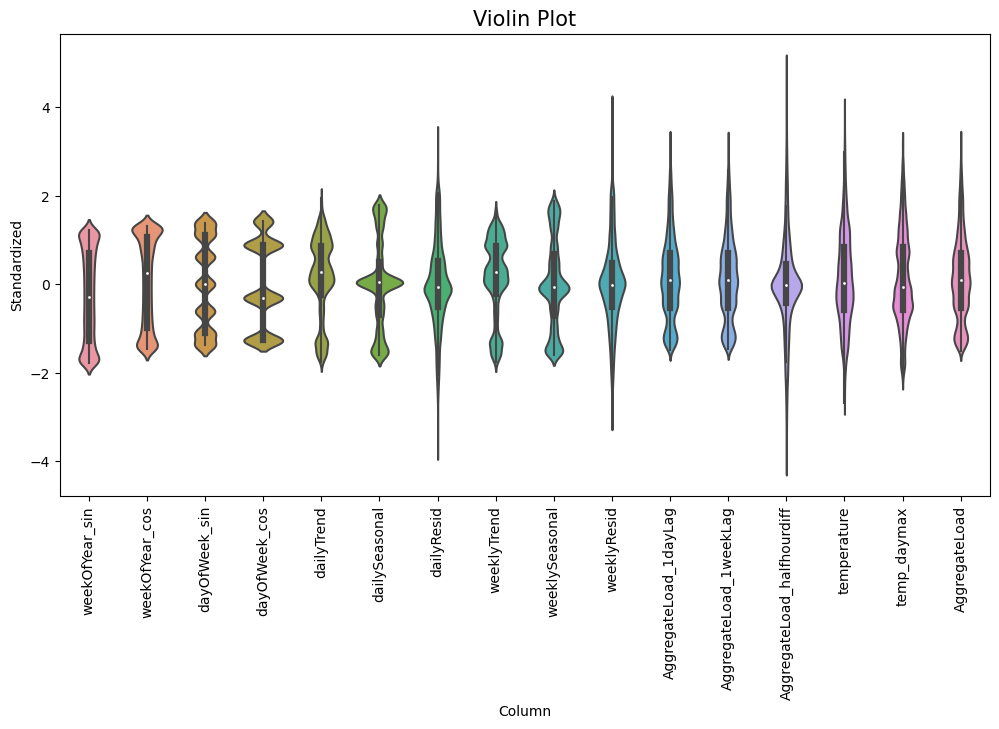

In [79]:
# Visualize distribution of the features
# df_std = (mergeData - train_mean) / train_std
df_std = mergeDataNormed.melt(var_name='Column', value_name='Standardized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Standardized', data=df_std, size=15)
_ = ax.set_xticklabels(mergeDataNormed.keys(), rotation=90)
plt.title('Violin Plot', size=15)
plt.savefig('violin_plot.png', format='png')


In [80]:
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score

# Split the data into features and target
X = mergeDataNormed.drop(columns=['AggregateLoad'])
y = mergeDataNormed['AggregateLoad']

# Calculate mutual information between each feature and the target variable
mutual_information_scores = []
for feature in X.columns:
    mutual_information_score = mutual_info_score(X[feature], y)
    mutual_information_scores.append([feature,mutual_information_score])
    
MISdf = pd.DataFrame(mutual_information_scores, columns=['Feature', 'Mutual information score'])
# Print the mutual information scores
# print('Mutual information scores:', mutual_information_scores)
print(MISdf.sort_values('Mutual information score', ascending=False))


                       Feature  Mutual information score
4                   dailyTrend                 10.576135
6                   dailyResid                 10.576135
7                  weeklyTrend                 10.576135
9                  weeklyResid                 10.576135
10       AggregateLoad_1dayLag                 10.575251
11      AggregateLoad_1weekLag                 10.575216
12  AggregateLoad_halfhourdiff                 10.573908
13                 temperature                  8.320157
14                 temp_daymax                  6.456107
8               weeklySeasonal                  5.816220
5                dailySeasonal                  3.870388
0               weekOfYear_sin                  3.767021
1               weekOfYear_cos                  3.691164
2                dayOfWeek_sin                  1.945128
3                dayOfWeek_cos                  1.945128


In [81]:
from pandas_profiling import ProfileReport

# profile = ProfileReport(mergeDataNormed, tsmode=True, sortby=mergeDataNormed.index.astype(int))
profile = ProfileReport(mergeDataNormed, tsmode=True)
profile.to_file('mergeDataNormed profile_report.html')
# profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Functions for preparing data for time series machine learning

Not my work

Credit to [Tensorflow Tutorial: Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [82]:
class WindowGenerator():
    # https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets
  def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data,
               label_columns=None):
    # print('\nWindowGenerator.__init__\n')
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    # print('\nlabel_columns:\n', label_columns)
    # Work out the label column indices.
    self.label_columns = label_columns
    self.num_out_features = train_df.shape[1] # default to predicting all input columns
    
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
      self.num_out_features = len(label_columns) # JS added this
      # print('\nself.num_out_features:', self.num_out_features)
      
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [83]:
def split_window(self, features):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#2_split
  # print('\nsplit_window\n', features)
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [84]:
def plot(self, model=None, plot_col='AggregateLoad', max_subplots=3):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#3_plot
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [85]:
def make_dataset(self, data):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#4_create_tfdatadatasets
  # print('\nmake_dataset\n', data)
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      seed=randomState,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [86]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#4_create_tfdatadatasets
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Create data windows for time series forecasting

Total window size: 96
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label column name(s): ['AggregateLoad']

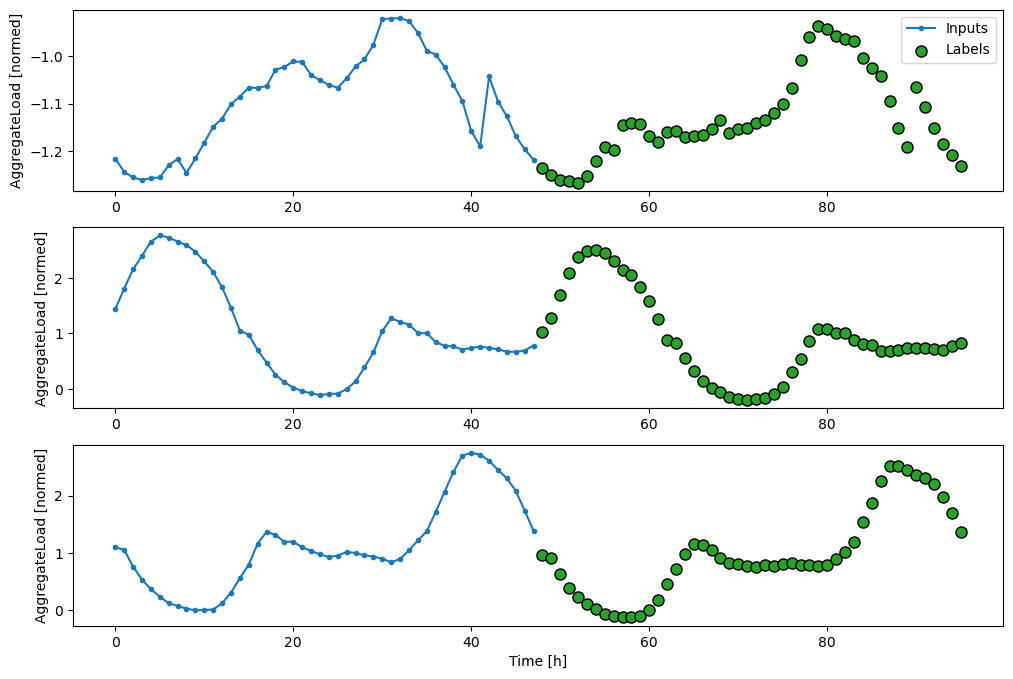

In [87]:
# Prepare data for one-shot multi-step
OUT_STEPS = 48 # 24 hour forecast
# IN_STEPS = 336 # look back 1 week
IN_STEPS = 48 # look back 1 day
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['AggregateLoad'],
                              train_df=train_data, val_df=val_data, test_df=test_data,)

num_out_features = multi_window.num_out_features
# print('\nnum_out_features: ', num_out_features)
multi_window.plot()
multi_window

# Build and Train models

## Baseline persistence model

Use a 1 week naive persistence model as a baseline to evaluate performance of the machine learning models we are building

Georgios Tziolis, Chrysovalantis Spanias, Maria Theodoride, Spyros Theocharides, Javier Lopez-Lorente, Andreas Livera, George Makrides, George E. Georghiou,

Short-term electric net load forecasting for solar-integrated distribution systems based on Bayesian neural networks and statistical post-processing,

Energy,
Volume 271,
2023,
127018,
ISSN 0360-5442,

https://doi.org/10.1016/j.energy.2023.127018.

In [88]:
# capture performnce of models
multi_val_performance = {}
multi_test_performance = {}

### Function to compile and fit models

In [89]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=5):
  # https://www.tensorflow.org/tutorials/structured_data/time_series#linear_model
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  checkpoint_filepath = '/tmp/' + model.name + '/checkpoint'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)
    
  # print('\nwindow.train:\n', window.train)  
  # print('\nwindow.val:\n', window.val)  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, checkpoint])

  # restore weights from epoch with best loss against validation dataset
  model.load_weights(checkpoint_filepath)
    
  return history


In [90]:
# Baseline Model: Naive 1 week persistence
OneWeekNPeriods = 48 * 7
NaiveForecast = mergeData.AggregateLoad.shift(OneWeekNPeriods).copy()

print(NaiveForecast.info())
print(NaiveForecast.describe())

<class 'pandas.core.series.Series'>
RangeIndex: 39223 entries, 0 to 39222
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
38887 non-null  float64
dtypes: float64(1)
memory usage: 306.6 KB
None
count    38887.000000
mean       899.531511
std        514.759447
min          7.664000
25%        535.666000
50%        876.124000
75%       1222.437533
max       2607.331610
Name: AggregateLoad, dtype: float64


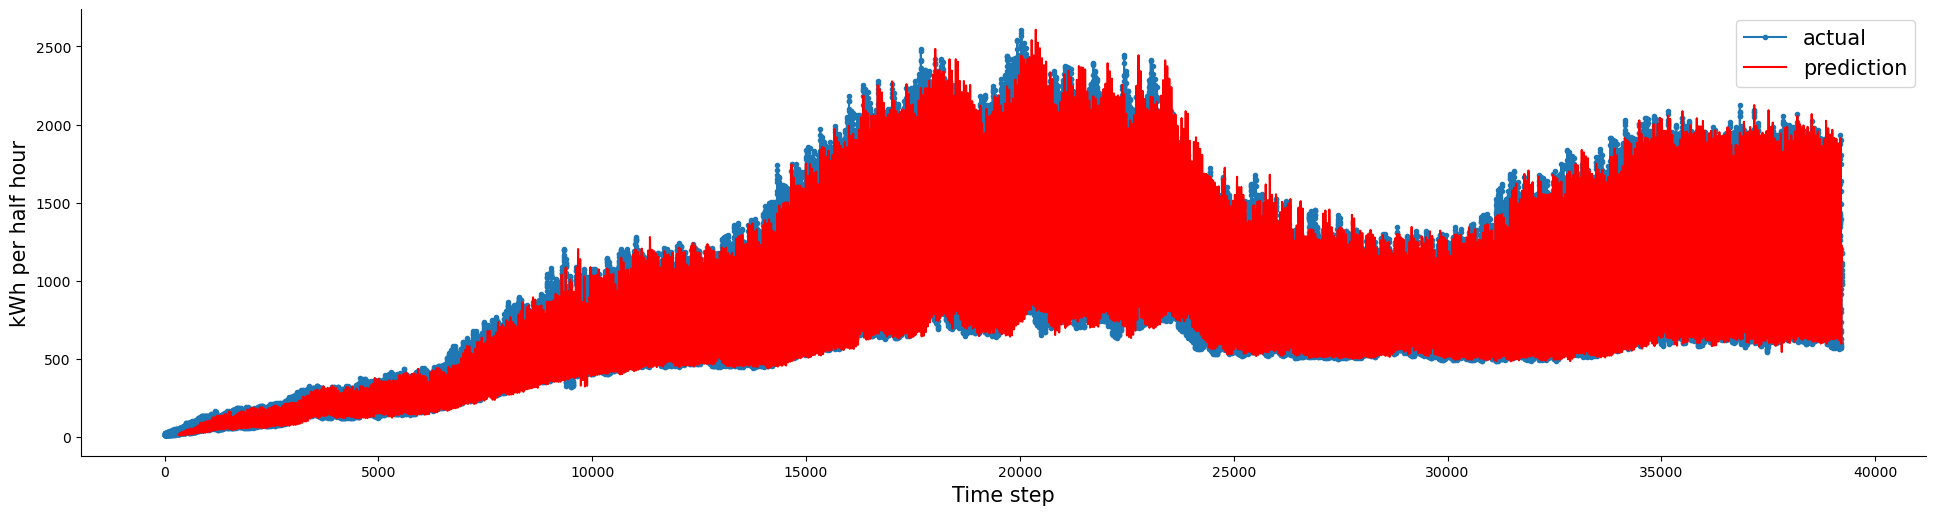

In [91]:
# visualize naive forecast and actuals for entire dataset
prediction_plot(mergeData.AggregateLoad, NaiveForecast)

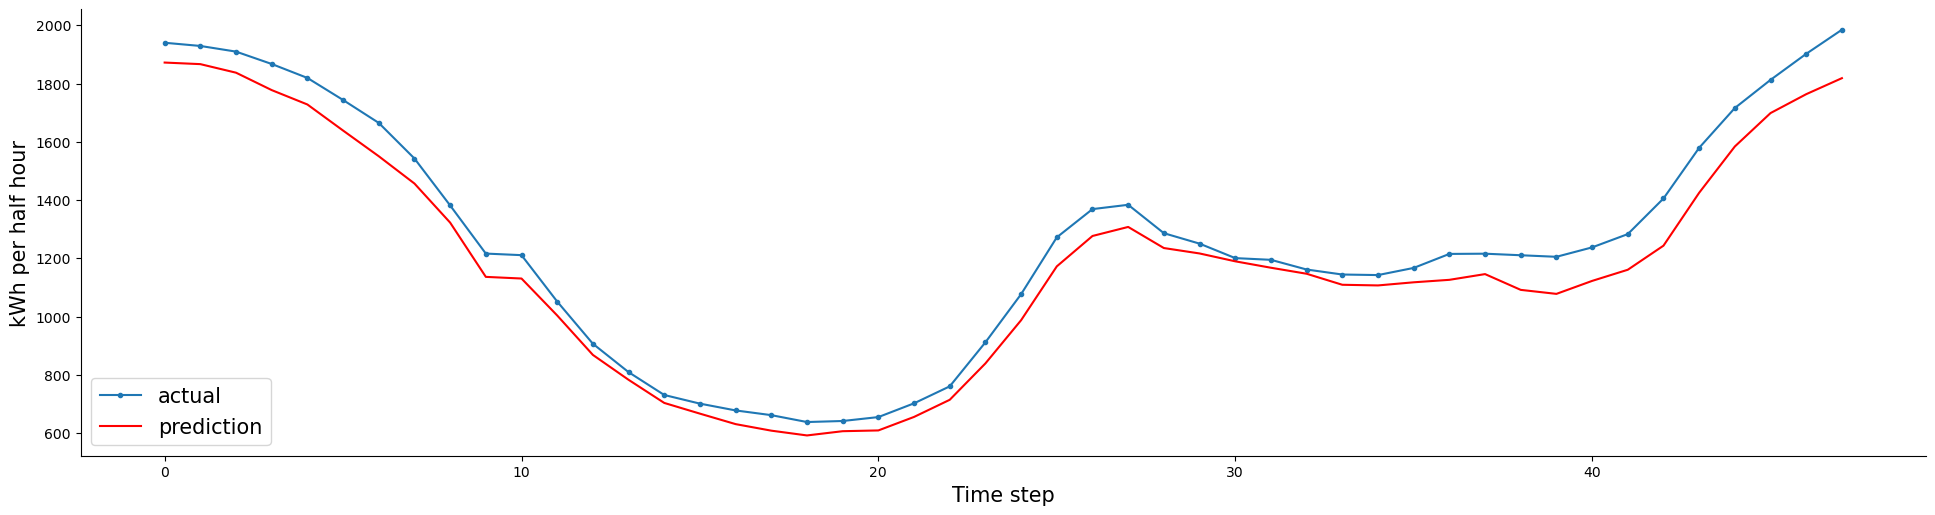

In [92]:
# visualize naive forecast and actuals for first 24 hours of the test dataset
# print(train_size, val_size, test_size)
# print(train_size+val_size)
prediction_plot(mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS])

In [93]:
# standardize the baseline 
NaiveForecastNormed = NaiveForecast.transform(lambda x: (x - train_mean) / train_std)
NaiveForecastNormed.describe()

weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos  \
count    38887.000000    38887.000000   38887.000000   38887.000000   
mean      1347.529003     1252.609278    1272.042605    1272.186512   
std        771.290029      716.852401     727.928348     728.010675   
min         11.198951       10.597363      10.840604      10.841873   
25%        802.330965      745.891303     757.495427     757.581141   
50%       1312.456349     1220.012051    1238.941724    1239.081888   
75%       1831.355375     1702.287198    1728.668411    1728.863961   
max       3906.411987     3630.886373    3687.065999    3687.483036   

         dailyTrend  dailySeasonal    dailyResid   weeklyTrend  \
count  38887.000000   38887.000000  38887.000000  38887.000000   
mean       0.145743       3.465533      5.250281      0.146462   
std        1.105761       1.983161      3.004322      1.109854   
min       -1.770089       0.029526      0.045021     -1.776460   
25%       -0.635881       2.063705      3.126631     -0.638054   
50%        0.095461       3.375353      5.113667      0.095994   
75%        0.839382       4.709560      7.134877      0.842668   
max        3.814291      10.044999     15.217619      3.828586   

       weeklySeasonal   weeklyResid  AggregateLoad_1dayLag  \
count    38887.000000  38887.000000           38887.000000   
mean         3.400235      5.310925               0.126432   
std          1.945845      3.039225               0.934410   
min          0.028882      0.045191              -1.492517   
25%          2.024785      3.162602              -0.534069   
50%          3.311752      5.172723               0.083942   
75%          4.620853      7.217416               0.712583   
max          9.855899     15.394061               3.226492   

       AggregateLoad_1weekLag  AggregateLoad_halfhourdiff   temperature  \
count            38887.000000                38887.000000  38887.000000   
mean                 0.142113                   14.185441    154.951137   
std                  0.924794                    8.117976     89.647850   
min                 -1.460177                    0.120309     -0.371908   
25%                 -0.511592                    8.447126     91.582197   
50%                  0.100060                   13.816294    150.874606   
75%                  0.722231                   19.277807    211.186784   
max                  3.210271                   41.118178    452.372793   

        temp_daymax  AggregateLoad  
count  38887.000000   38887.000000  
mean     144.726587       0.123444  
std       84.027045       0.935888  
min       -0.857902      -1.498066  
25%       85.330798      -0.538102  
50%      140.905649       0.080887  
75%      197.436331       0.710522  
max      423.500286       3.228407

In [94]:
# calculate error for baseline naive model (Normed)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# calculate error for naive model on validation set
valNaiveMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size:train_size+val_size], NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size])

# calculate error for naive model on test set
testNaiveMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size+val_size:], NaiveForecastNormed.AggregateLoad[train_size+val_size:])

print('valNaiveMAE: ', valNaiveMAE)
print('testNaiveMAE: ', testNaiveMAE)

valNaiveMAE:  0.0865885313197081
testNaiveMAE:  0.11861637054548187


In [95]:
# calculate error for baseline naive model (not normed)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print('Naive Root Mean Squared Error(RMSE): %.2f; Naive Mean Absolute Error(MAE) : %.2f; Naive Mean Absolute Percantage Error(MAPE) : %.2f '
      % (np.sqrt(mean_squared_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])),
         mean_absolute_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:]),
         mean_absolute_percentage_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])))

# calculate error for naive model on validation set
valNaiveMAE = mean_absolute_error(mergeData.AggregateLoad[train_size:train_size+val_size], NaiveForecast[train_size:train_size+val_size])

# calculate error for naive model on test set
testNaiveMAE = mean_absolute_error(mergeData.AggregateLoad[train_size+val_size:], NaiveForecast[train_size+val_size:])

print('valNaiveMAE: ', valNaiveMAE)
print('testNaiveMAE: ', testNaiveMAE)


Naive Root Mean Squared Error(RMSE): 94.09; Naive Mean Absolute Error(MAE) : 61.42; Naive Mean Absolute Percantage Error(MAPE) : 0.08 
valNaiveMAE:  47.62566179159976
testNaiveMAE:  65.24170187952366


In [96]:
# function for plotting the train and test loss curves
def plot_model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
    return

In [97]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Baseline'] = repeat_baseline.evaluate(mergeDataNormed.AggregateLoad[train_size:train_size+val_size], NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size], verbose=0)
multi_test_performance['Baseline'] = repeat_baseline.evaluate(mergeDataNormed.AggregateLoad[train_size+val_size:], NaiveForecastNormed.AggregateLoad[train_size+val_size:], verbose=0)
print(multi_val_performance['Baseline'], multi_test_performance['Baseline'])

[0.01635413058102131, 0.08658856153488159] [0.035601917654275894, 0.11861635744571686]


## Multi Layer Perceptron (MLP) Model

Epoch 1/100
839/856 [============================>.] - ETA: 0s - loss: 0.1467 - mean_absolute_error: 0.2526
Epoch 1: val_loss improved from inf to 0.09164, saving model to /tmp/MLP/checkpoint
856/856 [==============================] - 5s 4ms/step - loss: 0.1458 - mean_absolute_error: 0.2518 - val_loss: 0.0916 - val_mean_absolute_error: 0.2213
Epoch 2/100
844/856 [============================>.] - ETA: 0s - loss: 0.0819 - mean_absolute_error: 0.1910
Epoch 2: val_loss improved from 0.09164 to 0.07791, saving model to /tmp/MLP/checkpoint
856/856 [==============================] - 3s 4ms/step - loss: 0.0819 - mean_absolute_error: 0.1910 - val_loss: 0.0779 - val_mean_absolute_error: 0.2036
Epoch 3/100
853/856 [============================>.] - ETA: 0s - loss: 0.0728 - mean_absolute_error: 0.1797
Epoch 3: val_loss improved from 0.07791 to 0.07134, saving model to /tmp/MLP/checkpoint
856/856 [==============================] - 3s 4ms/step - loss: 0.0728 - mean_absolute_error: 0.1797 - val_loss

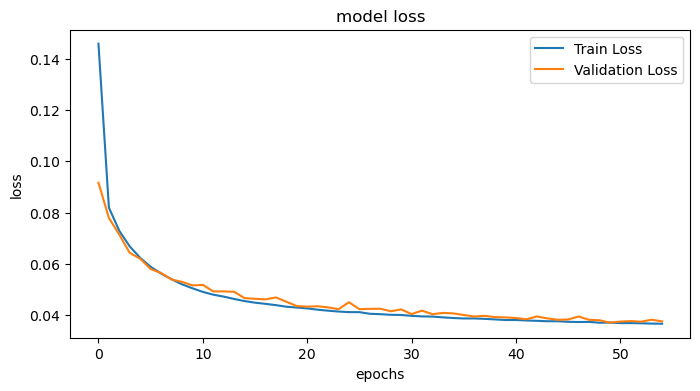

243/243 [==============================] - 1s 2ms/step - loss: 0.0371 - mean_absolute_error: 0.1408


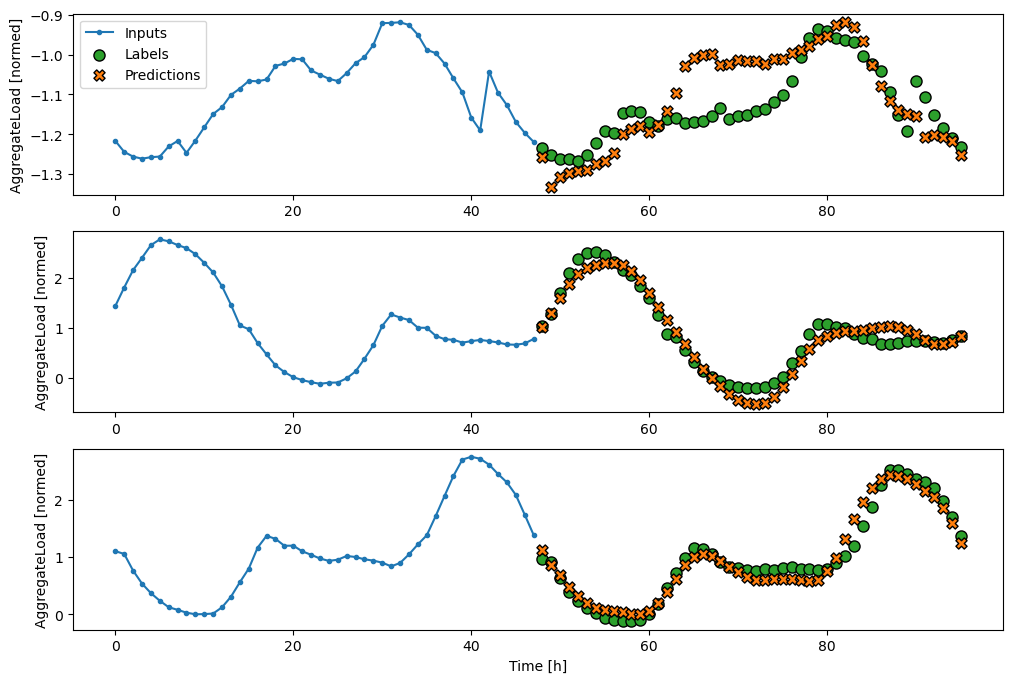

In [98]:
multi_MLP_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(32, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="MLP")

history = compile_and_fit(multi_MLP_model, multi_window)
multi_MLP_model.save('multi_MLP_model.keras')
plot_model_loss(history)

multi_val_performance['MLP'] = multi_MLP_model.evaluate(multi_window.val)
multi_test_performance['MLP'] = multi_MLP_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_MLP_model)

In [99]:
num_out_features

1

## Convolutional Neural Network (CNN) Model



Epoch 1/100
851/856 [============================>.] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1652
Epoch 1: val_loss improved from inf to 0.02964, saving model to /tmp/CNN/checkpoint
856/856 [==============================] - 4s 4ms/step - loss: 0.0681 - mean_absolute_error: 0.1650 - val_loss: 0.0296 - val_mean_absolute_error: 0.1303
Epoch 2/100
843/856 [============================>.] - ETA: 0s - loss: 0.0247 - mean_absolute_error: 0.1113
Epoch 2: val_loss improved from 0.02964 to 0.02260, saving model to /tmp/CNN/checkpoint
856/856 [==============================] - 3s 4ms/step - loss: 0.0246 - mean_absolute_error: 0.1112 - val_loss: 0.0226 - val_mean_absolute_error: 0.1140
Epoch 3/100
851/856 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_error: 0.1020
Epoch 3: val_loss improved from 0.02260 to 0.02106, saving model to /tmp/CNN/checkpoint
856/856 [==============================] - 3s 4ms/step - loss: 0.0205 - mean_absolute_error: 0.1020 - val_loss

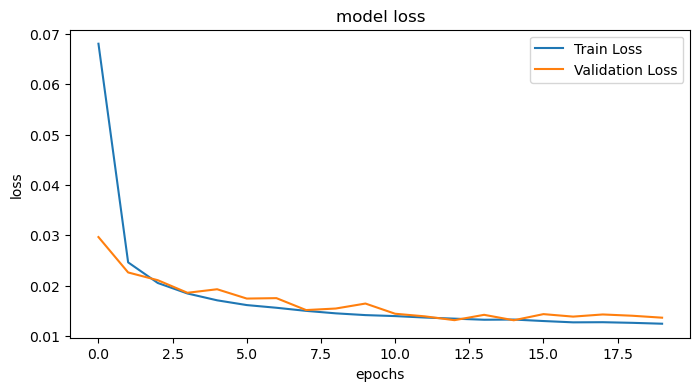

243/243 [==============================] - 1s 2ms/step - loss: 0.0131 - mean_absolute_error: 0.0875


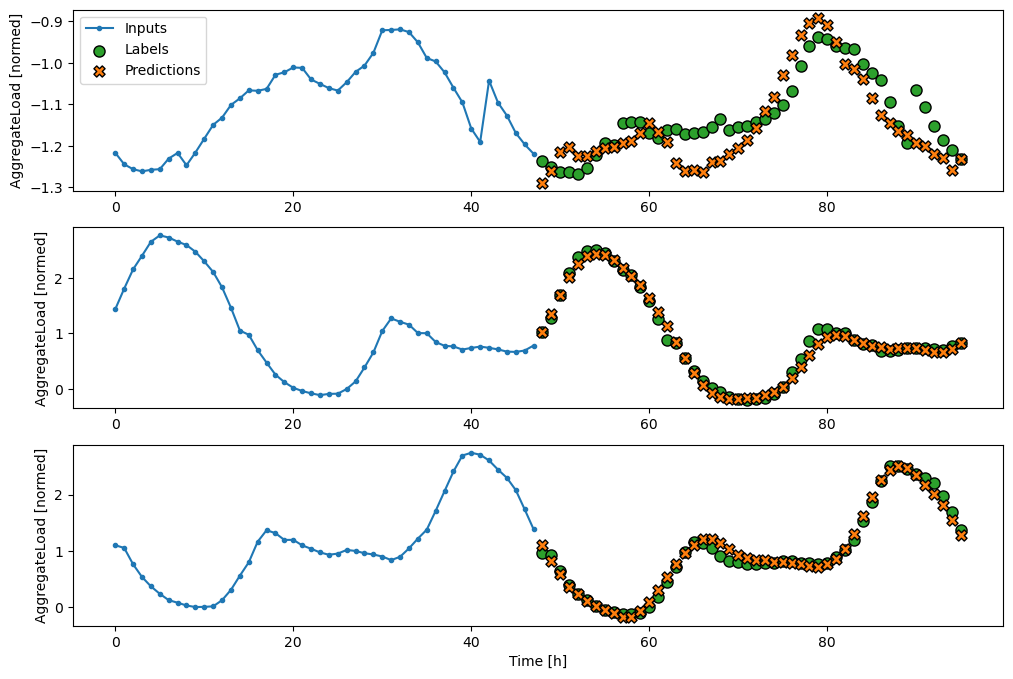

In [100]:
CONV_WIDTH = 10
multi_cnn_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    # tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="CNN")

history = compile_and_fit(multi_cnn_model, multi_window)
multi_cnn_model.save('multi_cnn_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['CNN'] = multi_cnn_model.evaluate(multi_window.val)
multi_test_performance['CNN'] = multi_cnn_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_cnn_model)


## Recurrent Neural Network (RNN) Model

Epoch 1/100
854/856 [============================>.] - ETA: 0s - loss: 0.0791 - mean_absolute_error: 0.1804
Epoch 1: val_loss improved from inf to 0.02333, saving model to /tmp/RNN/checkpoint
856/856 [==============================] - 12s 13ms/step - loss: 0.0791 - mean_absolute_error: 0.1803 - val_loss: 0.0233 - val_mean_absolute_error: 0.1177
Epoch 2/100
854/856 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_error: 0.0955
Epoch 2: val_loss improved from 0.02333 to 0.01572, saving model to /tmp/RNN/checkpoint
856/856 [==============================] - 15s 18ms/step - loss: 0.0173 - mean_absolute_error: 0.0955 - val_loss: 0.0157 - val_mean_absolute_error: 0.0956
Epoch 3/100
853/856 [============================>.] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0848
Epoch 3: val_loss improved from 0.01572 to 0.01472, saving model to /tmp/RNN/checkpoint
856/856 [==============================] - 11s 13ms/step - loss: 0.0138 - mean_absolute_error: 0.0848 - va

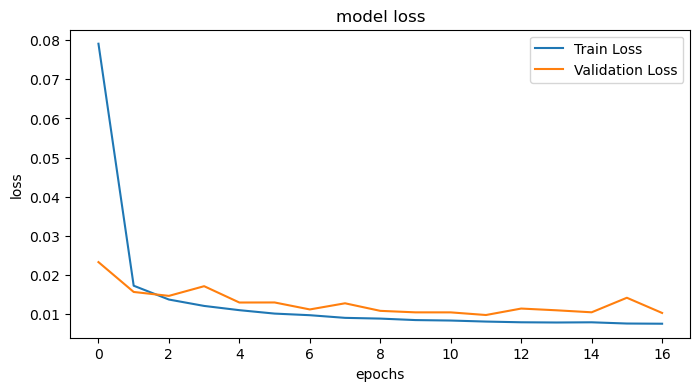

243/243 [==============================] - 1s 5ms/step - loss: 0.0098 - mean_absolute_error: 0.0732


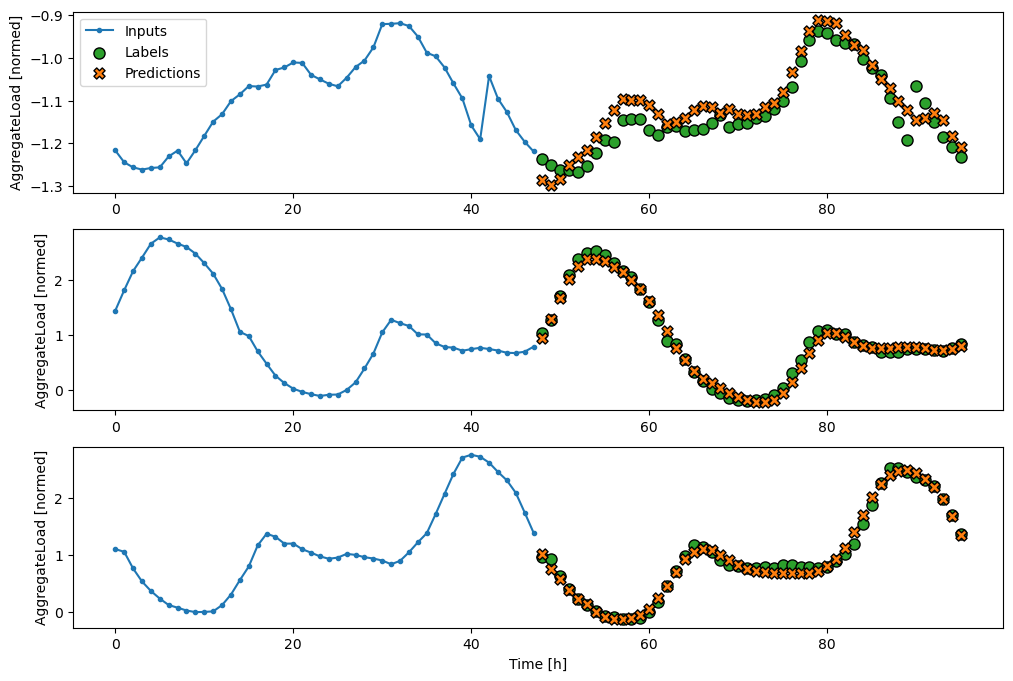

In [101]:
multi_rnn_model = tf.keras.Sequential([
    # tf.keras.layers.SimpleRNN(32, return_sequences=True),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="RNN")

history = compile_and_fit(multi_rnn_model, multi_window)
plot_model_loss(history)
multi_rnn_model.save('multi_rnn_model.keras')
# IPython.display.clear_output()

multi_val_performance['RNN'] = multi_rnn_model.evaluate(multi_window.val)
multi_test_performance['RNN'] = multi_rnn_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_rnn_model)

## Long Short Term Memory (LSTM) Model

Epoch 1/100
854/856 [============================>.] - ETA: 0s - loss: 0.0795 - mean_absolute_error: 0.1700
Epoch 1: val_loss improved from inf to 0.01733, saving model to /tmp/LSTM/checkpoint
856/856 [==============================] - 29s 31ms/step - loss: 0.0795 - mean_absolute_error: 0.1699 - val_loss: 0.0173 - val_mean_absolute_error: 0.1011
Epoch 2/100
855/856 [============================>.] - ETA: 0s - loss: 0.0120 - mean_absolute_error: 0.0781
Epoch 2: val_loss improved from 0.01733 to 0.01159, saving model to /tmp/LSTM/checkpoint
856/856 [==============================] - 27s 32ms/step - loss: 0.0120 - mean_absolute_error: 0.0781 - val_loss: 0.0116 - val_mean_absolute_error: 0.0814
Epoch 3/100
855/856 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0676
Epoch 3: val_loss improved from 0.01159 to 0.01068, saving model to /tmp/LSTM/checkpoint
856/856 [==============================] - 26s 31ms/step - loss: 0.0090 - mean_absolute_error: 0.0676 -

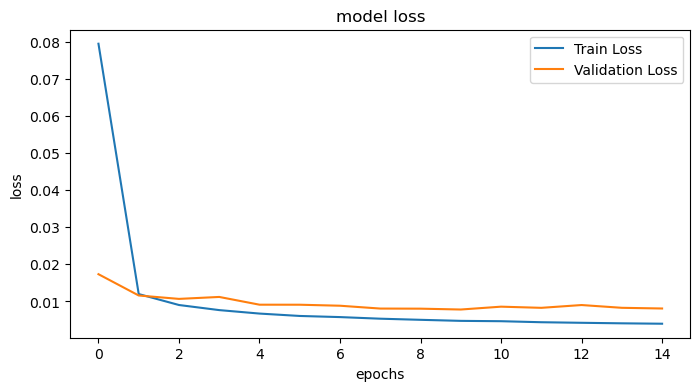

243/243 [==============================] - 2s 9ms/step - loss: 0.0078 - mean_absolute_error: 0.0639


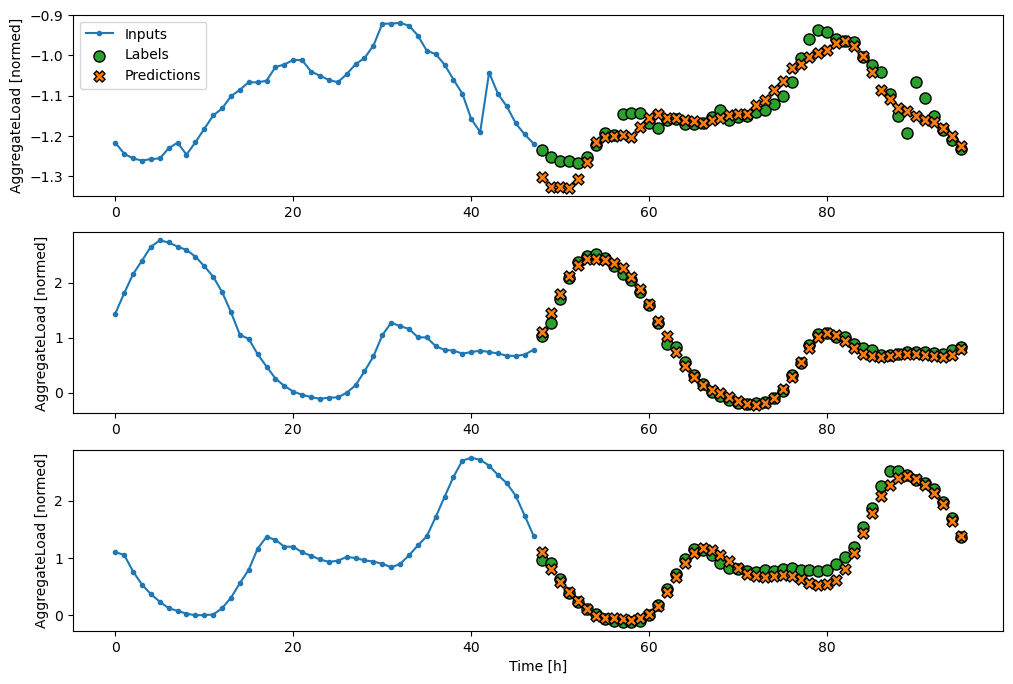

In [102]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.LSTM(64,return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="LSTM")

start_time = time.time()
history = compile_and_fit(multi_lstm_model, multi_window)
print('%s seconds' % (time.time() - start_time))
multi_lstm_model.save('multi_lstm_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_test_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


## GRU Model

Epoch 1/100
854/856 [============================>.] - ETA: 0s - loss: 0.0796 - mean_absolute_error: 0.1731
Epoch 1: val_loss improved from inf to 0.01794, saving model to /tmp/GRU/checkpoint
856/856 [==============================] - 29s 30ms/step - loss: 0.0795 - mean_absolute_error: 0.1730 - val_loss: 0.0179 - val_mean_absolute_error: 0.1039
Epoch 2/100
855/856 [============================>.] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0839
Epoch 2: val_loss improved from 0.01794 to 0.01253, saving model to /tmp/GRU/checkpoint
856/856 [==============================] - 25s 29ms/step - loss: 0.0139 - mean_absolute_error: 0.0839 - val_loss: 0.0125 - val_mean_absolute_error: 0.0853
Epoch 3/100
855/856 [============================>.] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0727
Epoch 3: val_loss improved from 0.01253 to 0.01032, saving model to /tmp/GRU/checkpoint
856/856 [==============================] - 25s 29ms/step - loss: 0.0105 - mean_absolute_error: 0.0727 - va

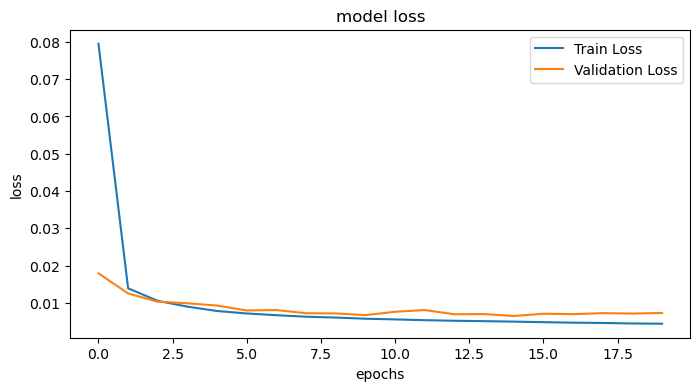

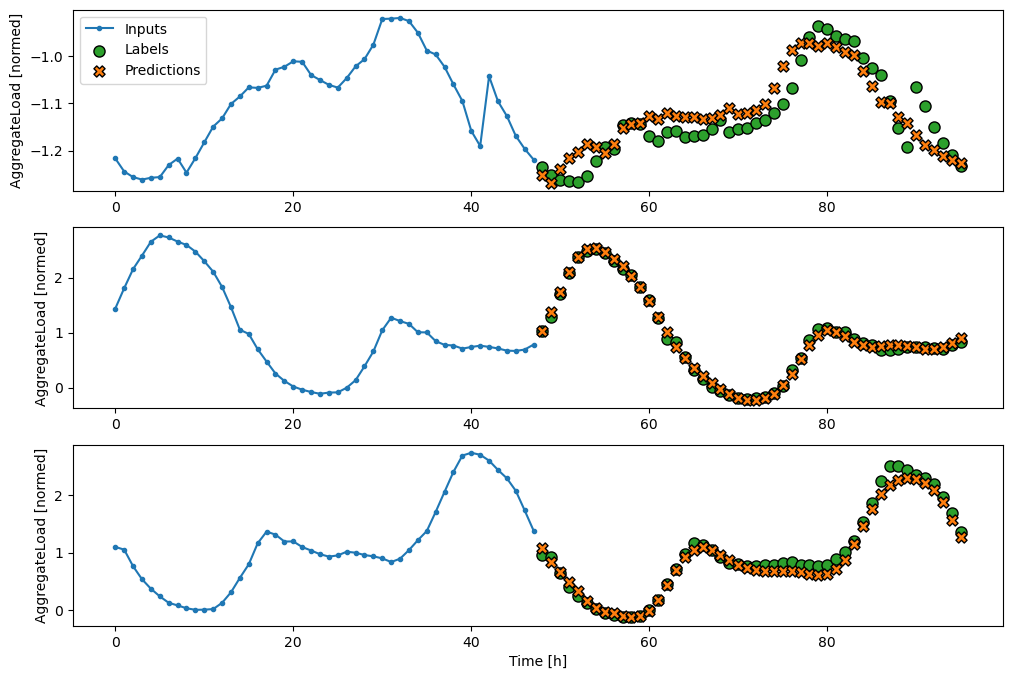

In [103]:
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    # tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(64, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="GRU")

start_time = time.time()
history = compile_and_fit(multi_gru_model, multi_window)
print('%s seconds' % (time.time() - start_time))
multi_gru_model.save('multi_gru_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['GRU'] = multi_gru_model.evaluate(multi_window.val, verbose=0)
multi_test_performance['GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_gru_model)

# Model Evaluation and Selection

print('\nValidation Performance:\n', multi_val_performance)
print('\nTest Performance:\n', multi_test_performance)

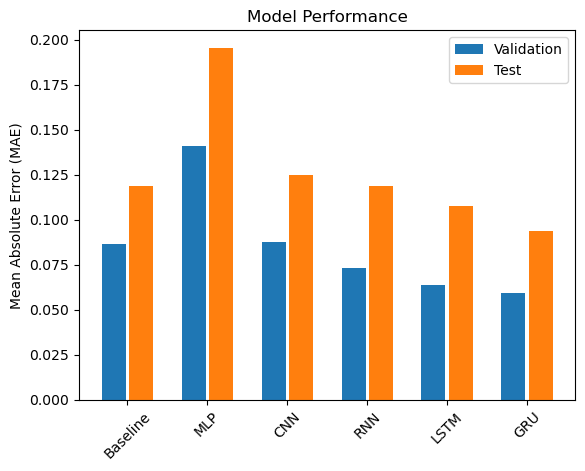

In [104]:
x = np.arange(len(multi_test_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_test_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_test_performance.keys(),
           rotation=45)
plt.ylabel(f'Mean Absolute Error (MAE)')
_ = plt.legend()
plt.title(f'Model Performance')
plt.savefig('model performance.png', format='png')


In [105]:
CONV_WIDTH = 10 # CNN model would not load without this...
# restore models from file
multi_MLP_model = tf.keras.models.load_model('multi_MLP_model.keras')
multi_cnn_model = tf.keras.models.load_model('multi_cnn_model.keras')
multi_rnn_model = tf.keras.models.load_model('multi_rnn_model.keras')
multi_lstm_model = tf.keras.models.load_model('multi_lstm_model.keras')
multi_gru_model = tf.keras.models.load_model('multi_gru_model.keras')
model_list = [multi_MLP_model, multi_cnn_model, multi_rnn_model, multi_lstm_model, multi_gru_model]


In [106]:
for model in model_list:
    print(model.name)

MLP
CNN
RNN
LSTM
GRU


In [107]:
# store the evaluation results for all models
import pickle
with open('model eval results.pkl', 'wb') as f:
    pickle.dump(multi_val_performance, f)

with open('model test results.pkl', 'wb') as f:
    pickle.dump(multi_test_performance, f)

In [108]:
# load the evaluation results for all models
with open('model eval results.pkl', 'rb') as f:
    multi_val_performance = pickle.load(f)

with open('model test results.pkl', 'rb') as f:
    multi_test_performance = pickle.load(f)

print(multi_val_performance)
print(multi_test_performance)

{'Baseline': [0.01635413058102131, 0.08658856153488159], 'MLP': [0.03707849234342575, 0.14084720611572266], 'CNN': [0.013091934844851494, 0.08751280605792999], 'RNN': [0.009832922369241714, 0.07316559553146362], 'LSTM': [0.007811581715941429, 0.06389348953962326], 'GRU': [0.006493003107607365, 0.05943519249558449]}
{'Baseline': [0.035601917654275894, 0.11861635744571686], 'MLP': [0.07000672072172165, 0.19544857740402222], 'CNN': [0.027758680284023285, 0.12467614561319351], 'RNN': [0.026572614908218384, 0.11867942661046982], 'LSTM': [0.022313298657536507, 0.10747652500867844], 'GRU': [0.016824450343847275, 0.09391609579324722]}


## Feature Evaluation (methods that require models already built)

In [109]:
# function to create time series dataset for feature permutation
def generateFeatPermWindow(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=None,
                                cols_to_shuffle=None,
                              train_df=train_data, val_df=val_data, test_df=test_data):
    
    train = train_df.copy()
    val = val_df.copy()
    test = test_df.copy()
    
    # randomly shuffle shuffle the specified columns
    for col in cols_to_shuffle:
        train[col] = train[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
        val[col] = val[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
        test[col] = test[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
    
    """
    print('train NaNs: ', train.isnull().sum().sum())
    print('val NaNs: ', val.isnull().sum().sum())
    print('val NaNs:\n', val[val.isna().any(axis=1)])
    print('test NaNs: ', test.isnull().sum().sum())
    print('test NaNs:\n', test[test.isna().any(axis=1)])
    """

    feat_perm_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=label_columns,
                              train_df=train, val_df=val, test_df=test,)
    
    return feat_perm_window


In [110]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Define a function to calculate the permutation importance of a feature group for a given model
def calculate_permutation_importance_group(model, feature_group, baseline_val_perf, baseline_test_perf):
    """Calculates the permutation importance of a feature group for a given model.

    Args:
        model: The model to calculate the permutation importance for.
        feature_group: A list of the features in the feature group.
        baseline_val_perf: baseline performance (in MAE) of the model using all features for the validation set
        baseline_test_perf: baseline performance (in MAE) of the model using all features for the test set
        
    Returns:
        The permutation importance of the feature group for the given model.
    """

    # Shuffle the values of the features in the feature group
    feat_perm_window = generateFeatPermWindow(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=label_columns,
                                cols_to_shuffle=feature_group,
                              train_df=train_data, val_df=val_data, test_df=test_data)
    
    # model.fit(X_shuffled, y)
    val_perf_shuffle = model.evaluate(feat_perm_window.val, verbose=1)[1] # MAE

    # Calculate the permutation importance
    # importance = np.mean(y - y_pred)
    importance = val_perf_shuffle - baseline_val_perf
    
    print('\nModel: ', model.name, feature_group, 'importance: ', importance)

    return importance

In [111]:
# Define a function to visualize the permutation importances for a given feature using a stacked bar chart
def visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances):
    """Visualizes the permutation importances for a given feature using a stacked bar chart created with the plt.stackplot() function.

    Args:
        feature: The feature to visualize the permutation importances for.
        permutation_importances: A dictionary mapping the model names to the permutation importances for the given feature.
    """

    # Get the permutation importances for each feature in a list
    importances = sorted(permutation_importances.items(), key=itemgetter(1), reverse=True)
    permutation_importances_values = list(importances.values())

    # Create a bar chart of the permutation importances
    plt.bar(importances.keys(), permutation_importances_values)
    plt.xlabel('Feature')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Importances for Model: {}'.format(model))
    plt.legend(importances.keys())
    plt.tick_params(rotation=45)
    plt.show()

## Permutation Feature Importance

In [112]:
# Calculate the permutation feature importance for each model and visualize the results
# cyclically encoded features need to be grouped together for the purposes of feature permutation importance
feature_groups = {
    'weekOfYear': ['weekOfYear_sin', 'weekOfYear_cos'],
    'dayOfWeek': ['dayOfWeek_sin', 'dayOfWeek_cos'],
#    'minuteOfDay': ['minuteOfDay_sin', 'minuteOfDay_cos'],
}

grouped_features = [value for key, value in feature_groups.items() for value in value]
print('grouped_features: ', grouped_features, '\n')

# add individual features as feature groups of one
for feature in val_data.columns:
    if feature not in grouped_features:
        feature_groups[feature] = [feature]

print('feature_groups: ', feature_groups)

permutation_importances_groups = {}
for model in model_list:
    # calculate baseline model performance with all features
    print('\ncalculate baseline model performance with all features.\n', model.name)
    val_perf = model.evaluate(multi_window.val, verbose=1)[1] # MAE
    test_perf = model.evaluate(multi_window.test, verbose=1)[1] # MAE

    for feature_group_name, feature_group in feature_groups.items():
        permutation_importance = calculate_permutation_importance_group(model, feature_group, val_perf, test_perf)
        if model.name not in permutation_importances_groups:
            permutation_importances_groups[model.name] = {}
        permutation_importances_groups[model.name][feature_group_name] = permutation_importance


grouped_features:  ['weekOfYear_sin', 'weekOfYear_cos', 'dayOfWeek_sin', 'dayOfWeek_cos'] 

feature_groups:  {'weekOfYear': ['weekOfYear_sin', 'weekOfYear_cos'], 'dayOfWeek': ['dayOfWeek_sin', 'dayOfWeek_cos'], 'dailyTrend': ['dailyTrend'], 'dailySeasonal': ['dailySeasonal'], 'dailyResid': ['dailyResid'], 'weeklyTrend': ['weeklyTrend'], 'weeklySeasonal': ['weeklySeasonal'], 'weeklyResid': ['weeklyResid'], 'AggregateLoad_1dayLag': ['AggregateLoad_1dayLag'], 'AggregateLoad_1weekLag': ['AggregateLoad_1weekLag'], 'AggregateLoad_halfhourdiff': ['AggregateLoad_halfhourdiff'], 'temperature': ['temperature'], 'temp_daymax': ['temp_daymax'], 'AggregateLoad': ['AggregateLoad']}

calculate baseline model performance with all features.
 MLP
243/243 [==============================] - 1s 2ms/step - loss: 0.0518 - mean_absolute_error: 0.1667

Model:  MLP ['weekOfYear_sin', 'weekOfYear_cos'] importance:  0.025822877883911133
243/243 [==============================] - 1s 2ms/step - loss: 0.0770 - mean_

In [113]:
permutation_importances_groups

{'MLP': {'weekOfYear': 0.025822877883911133,
  'dayOfWeek': 0.050771161913871765,
  'dailyTrend': 0.035018593072891235,
  'dailySeasonal': 0.6306884288787842,
  'dailyResid': 0.09346866607666016,
  'weeklyTrend': 0.03116987645626068,
  'weeklySeasonal': 0.53030925989151,
  'weeklyResid': 0.06114968657493591,
  'AggregateLoad_1dayLag': 0.07765400409698486,
  'AggregateLoad_1weekLag': 0.017686769366264343,
  'AggregateLoad_halfhourdiff': 0.14925137162208557,
  'temperature': 0.12771862745285034,
  'temp_daymax': 0.12611740827560425,
  'AggregateLoad': 0.511471152305603},
 'CNN': {'weekOfYear': 0.02063082903623581,
  'dayOfWeek': 0.04768596589565277,
  'dailyTrend': 0.031188584864139557,
  'dailySeasonal': 0.43928371369838715,
  'dailyResid': 0.12180866301059723,
  'weeklyTrend': 0.024429768323898315,
  'weeklySeasonal': 0.1682000309228897,
  'weeklyResid': 0.059718742966651917,
  'AggregateLoad_1dayLag': 0.035155288875103,
  'AggregateLoad_1weekLag': 0.031670019030570984,
  'AggregateLoa

In [114]:
from operator import itemgetter, attrgetter
# Define a function to visualize the permutation importances for a given feature using a stacked bar chart
def visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances):
    """Visualizes the permutation importances for a given feature using a stacked bar chart created with the plt.stackplot() function.

    Args:
        feature: The feature to visualize the permutation importances for.
        permutation_importances: A dictionary mapping the model names to the permutation importances for the given feature.
    """

    # Get the permutation importances for each feature in a list
    importances = sorted(permutation_importances.items(), key=itemgetter(1), reverse=True)
    print(importances)
    df = pd.DataFrame(importances, columns=['label', 'value'])
    labels = df['label'].tolist()
    values = df['value'].tolist()


    # Create a stacked bar chart of the permutation importances
    plt.bar(labels, values)
    plt.xlabel('Feature')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Importances for Model: {}'.format(model))
    plt.legend(labels)
    plt.tick_params(rotation=90)
    plt.show()

[('dailySeasonal', 0.6306884288787842), ('weeklySeasonal', 0.53030925989151), ('AggregateLoad', 0.511471152305603), ('AggregateLoad_halfhourdiff', 0.14925137162208557), ('temperature', 0.12771862745285034), ('temp_daymax', 0.12611740827560425), ('dailyResid', 0.09346866607666016), ('AggregateLoad_1dayLag', 0.07765400409698486), ('weeklyResid', 0.06114968657493591), ('dayOfWeek', 0.050771161913871765), ('dailyTrend', 0.035018593072891235), ('weeklyTrend', 0.03116987645626068), ('weekOfYear', 0.025822877883911133), ('AggregateLoad_1weekLag', 0.017686769366264343)]


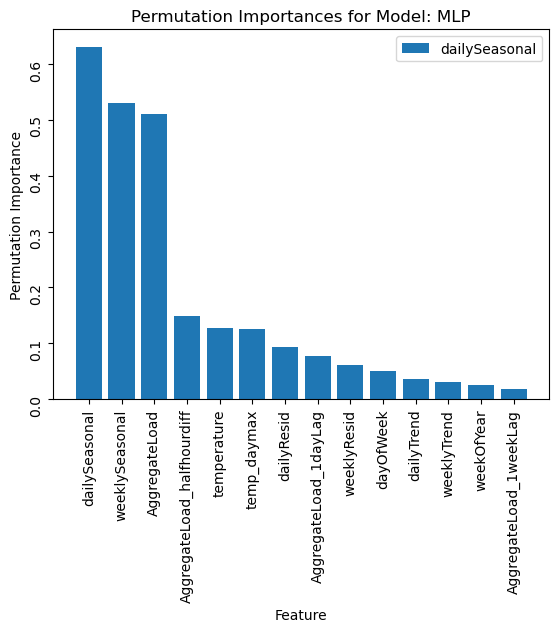

[('AggregateLoad', 0.5644100159406662), ('dailySeasonal', 0.43928371369838715), ('AggregateLoad_halfhourdiff', 0.19119884073734283), ('weeklySeasonal', 0.1682000309228897), ('dailyResid', 0.12180866301059723), ('weeklyResid', 0.059718742966651917), ('dayOfWeek', 0.04768596589565277), ('AggregateLoad_1dayLag', 0.035155288875103), ('AggregateLoad_1weekLag', 0.031670019030570984), ('dailyTrend', 0.031188584864139557), ('temperature', 0.02802468091249466), ('temp_daymax', 0.027749724686145782), ('weeklyTrend', 0.024429768323898315), ('weekOfYear', 0.02063082903623581)]


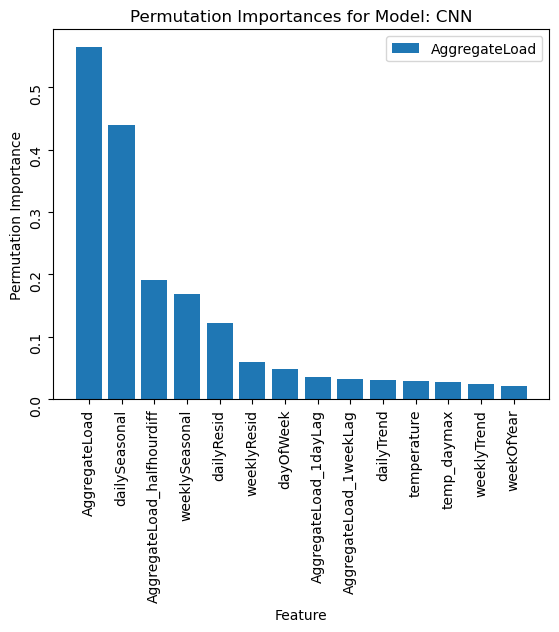

[('AggregateLoad', 0.6077499985694885), ('dailySeasonal', 0.19498178362846375), ('weeklySeasonal', 0.12946635484695435), ('AggregateLoad_halfhourdiff', 0.0832323431968689), ('dailyTrend', 0.0795404464006424), ('dailyResid', 0.044907547533512115), ('weeklyTrend', 0.03324035555124283), ('weekOfYear', 0.03285915404558182), ('weeklyResid', 0.030880168080329895), ('dayOfWeek', 0.02271873503923416), ('AggregateLoad_1dayLag', 0.019381053745746613), ('AggregateLoad_1weekLag', 0.014816507697105408), ('temp_daymax', 0.011123321950435638), ('temperature', 0.009551770985126495)]


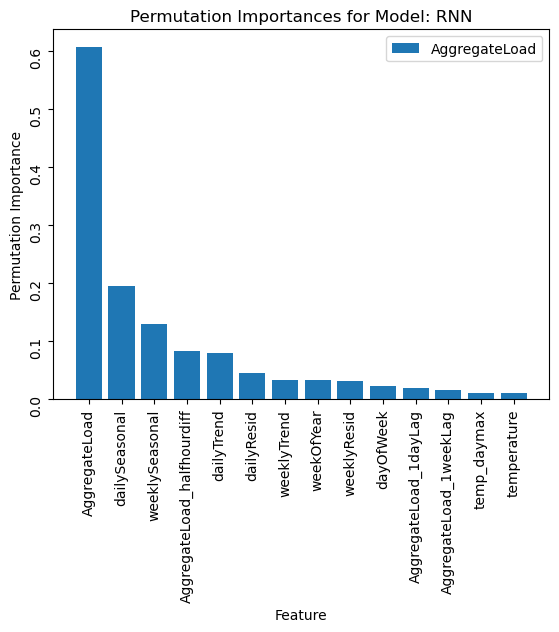

[('AggregateLoad', 0.5960425212979317), ('dailySeasonal', 0.13466312736272812), ('AggregateLoad_halfhourdiff', 0.09498945623636246), ('weeklySeasonal', 0.06704836338758469), ('dailyResid', 0.04150041192770004), ('dayOfWeek', 0.0240267813205719), ('weekOfYear', 0.022418715059757233), ('weeklyResid', 0.02005840092897415), ('dailyTrend', 0.020026326179504395), ('weeklyTrend', 0.015682078897953033), ('temp_daymax', 0.010367892682552338), ('AggregateLoad_1dayLag', 0.009174227714538574), ('AggregateLoad_1weekLag', 0.006077796220779419), ('temperature', 0.005948148667812347)]


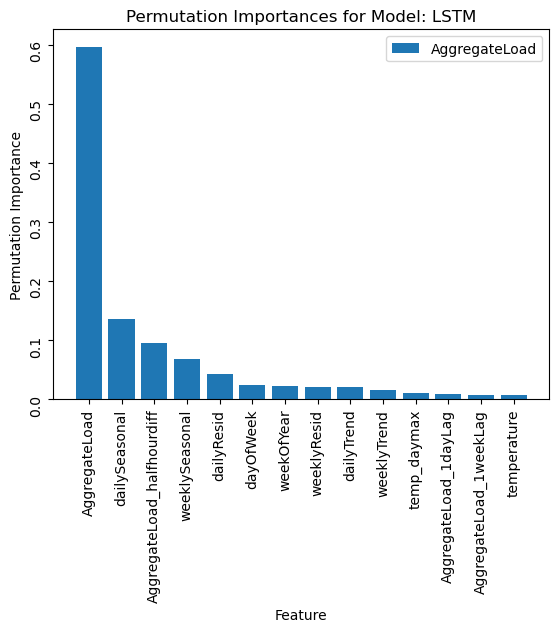

[('AggregateLoad', 0.5870638452470303), ('dailySeasonal', 0.25695013627409935), ('AggregateLoad_halfhourdiff', 0.12151313945651054), ('weeklySeasonal', 0.09235451743006706), ('dailyResid', 0.06788235530257225), ('dailyTrend', 0.04212946072220802), ('weeklyResid', 0.037177082151174545), ('weeklyTrend', 0.03413695469498634), ('dayOfWeek', 0.02551385387778282), ('weekOfYear', 0.024090643972158432), ('temp_daymax', 0.016407106071710587), ('AggregateLoad_1dayLag', 0.011992339044809341), ('temperature', 0.006855454295873642), ('AggregateLoad_1weekLag', 0.004912186414003372)]


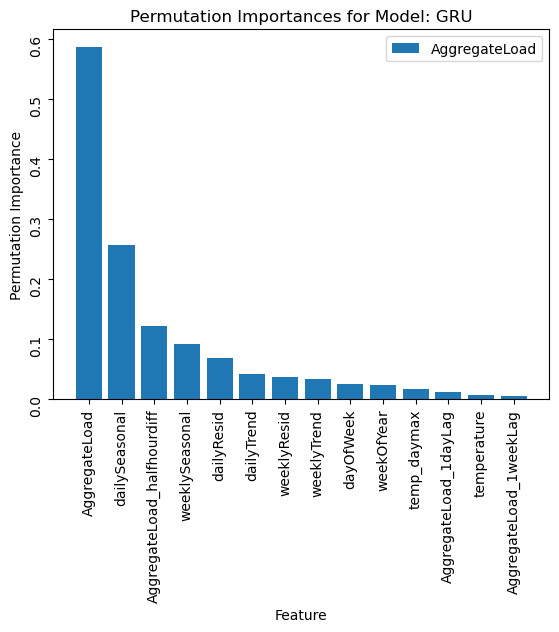

In [115]:
# Visualize the permutation importances for each feature using a stacked bar chart
for model, permutation_importances in permutation_importances_groups.items():
    visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances)

# Best Model Results

## Single Day results: Benchmark, GRU model and actuals

In [116]:
# build a single record dataset from start of the test dataset
# print(mergeDataNormed)
# print(train_size+test_size-IN_STEPS)
# print(mergeDataNormed.iloc[train_size+test_size-IN_STEPS:train_size+test_size])

oneDay_ds = tf.keras.utils.timeseries_dataset_from_array(
      data=test_data[:IN_STEPS],
      targets=None,
      sequence_length=IN_STEPS,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

# get the prediction
testYhatNormed = multi_gru_model.predict(oneDay_ds)

1/1 [==============================] - 0s 399ms/step


In [117]:
# print(testYhatNormed) # prediction for all input columns
print(testYhatNormed[0,:,-1]) # prediction for target column, aggregate load

[ 2.0799148   2.118247    2.0919237   2.0288327   1.91727     1.723032
  1.4790183   1.2172168   0.956442    0.6712042   0.44488576  0.2882775
  0.1437967   0.01195371 -0.1215569  -0.24514237 -0.3315105  -0.38807338
 -0.40499777 -0.42297032 -0.38782597 -0.29920098 -0.11729465  0.14864236
  0.43042964  0.64150226  0.7396052   0.7275554   0.6607423   0.5645767
  0.48560172  0.45701367  0.4518373   0.44677466  0.4595212   0.45467836
  0.48759192  0.49655676  0.51726216  0.501192    0.53311366  0.64931154
  0.86125684  1.1321309   1.440476    1.7139784   1.9184703   2.0093875 ]


In [118]:
# Invert standardization
testYhat = (np.array(testYhatNormed) * np.array(train_std)) + np.array(train_mean)

# print(testYhat)
print(testYhat[0,:,-1])

[1975.6349811  1996.71857615 1982.24015223 1947.53864533 1886.17660681
 1779.34131752 1645.12825021 1501.13148052 1357.6993809  1200.81210877
 1076.33181404  990.19371224  910.72598058  838.20933948  764.77546604
  696.80064642  649.29620291  618.18533741  608.87654275  598.99122664
  618.32142342  667.06718053  767.1198025   913.39120595 1068.38061751
 1184.47536167 1238.43420311 1231.80654221 1195.05781125 1142.16454525
 1098.72651963 1083.00243825 1080.15531955 1077.37075255 1084.38164097
 1081.71796464 1099.8211744  1104.75203845 1116.14048046 1107.30151202
 1124.85916473 1188.77064404 1305.34537744 1454.33225171 1623.92905909
 1774.36163823 1886.8368092  1936.84335354]


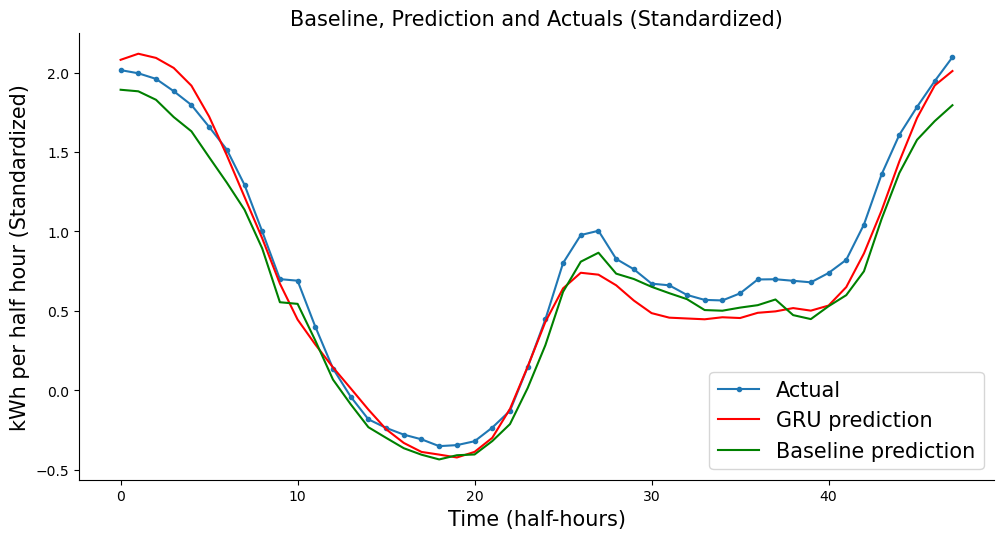

<Figure size 640x480 with 0 Axes>

In [119]:
# Plot Naive prediction, GRU prediction and Actuals for first 24 hours of the test set (normed values)
len_prediction=[x for x in range(len(testYhat[0,:,-1]))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="actual")
plt.plot(len_prediction, mergeDataNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], marker='.', label="Actual")
plt.plot(len_prediction, testYhatNormed[0,:,-1], 'r', label="GRU prediction")
plt.plot(len_prediction, NaiveForecastNormed[train_size+val_size:train_size+val_size+OUT_STEPS].AggregateLoad, 'g', label="Baseline prediction")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('kWh per half hour (Standardized)', size=15)
plt.xlabel('Time (half-hours)', size=15)
plt.legend(fontsize=15)
plt.title('Baseline, Prediction and Actuals (Standardized)', size=15)
plt.show();
plt.savefig('Baseline, Prediction and Actuals (Standardized).png', format='png')

In [120]:
# calculate error for baseline naive model (Normed) first 24 hours of test set
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# calculate error for baseline naive model on validation set
valBaselineMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size:train_size+OUT_STEPS], NaiveForecastNormed.AggregateLoad[train_size:train_size+OUT_STEPS])

# calculate error for baseline naive model on test set
testBaselineMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecastNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS])

print('valBaselineMAE: ', valBaselineMAE)
print('testBaselineMAE: ', testBaselineMAE)

valBaselineMAE:  0.04941361221848661
testBaselineMAE:  0.13629643627859406


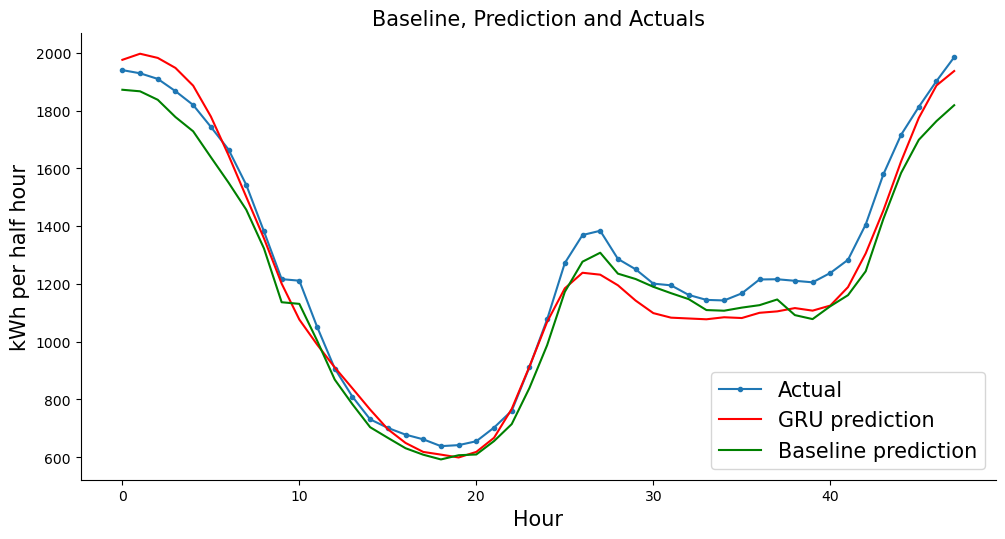

<Figure size 640x480 with 0 Axes>

In [121]:
len_prediction=[x for x in range(len(testYhat[0,:,-1]))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="actual")
plt.plot(len_prediction, mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], marker='.', label="Actual")
plt.plot(len_prediction, testYhat[0,:,-1], 'r', label="GRU prediction")
plt.plot(len_prediction, NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS], 'g', label="Baseline prediction")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('kWh per half hour', size=15)
plt.xlabel('Hour', size=15)
plt.legend(fontsize=15)
plt.title('Baseline, Prediction and Actuals', size=15)
plt.show()
plt.savefig('Baseline, Prediction and Actuals.png', format='png')

In [122]:
# calculate error for baseline naive model first 24 hours of test set
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# calculate error for baseline naive model on test set
testBaselineMAE1day = mean_absolute_error(mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS])

# calculate error for baseline naive model on test set
testModelMAE1day = mean_absolute_error(mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], testYhat[0,:,-1])

print('testBaselineMAE1day: ', testBaselineMAE1day)
print('testModelMAE1day: ', testModelMAE1day)
print('Model accuracy absolute improvement: ', testBaselineMAE1day - testModelMAE1day)
print('Model accuracy % improvement: ', (testBaselineMAE1day - testModelMAE1day) / testBaselineMAE1day * 100)

testBaselineMAE1day:  74.9661401882123
testModelMAE1day:  64.19646290299757
Model accuracy absolute improvement:  10.769677285214726
Model accuracy % improvement:  14.366055472745487


## Aggregate results for Test period: Benchmark, GRU model and actuals

In [123]:
# build dataset for the test dataset

ds = tf.keras.utils.timeseries_dataset_from_array(
      data=test_data,
      targets=None,
      sequence_length=IN_STEPS,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

# get the prediction
testYhatNormed = multi_gru_model.predict(ds)

122/122 [==============================] - 1s 8ms/step


In [124]:
print(testYhatNormed.shape)
print(testYhatNormed)

(3876, 48, 1)
[[[2.079915  ]
  [2.118247  ]
  [2.091924  ]
  ...
  [1.7139785 ]
  [1.9184703 ]
  [2.0093875 ]]

 [[2.0820155 ]
  [2.0714147 ]
  [2.0084302 ]
  ...
  [1.9359866 ]
  [2.03258   ]
  [2.0232167 ]]

 [[2.0824893 ]
  [2.029721  ]
  [1.9217249 ]
  ...
  [2.0681949 ]
  [2.0765548 ]
  [2.015433  ]]

 ...

 [[0.29687783]
  [0.29824203]
  [0.30857646]
  ...
  [0.31336457]
  [0.24732955]
  [0.24609862]]

 [[0.3080243 ]
  [0.30792817]
  [0.309067  ]
  ...
  [0.26422054]
  [0.22974768]
  [0.24118045]]

 [[0.3238561 ]
  [0.31515563]
  [0.29956505]
  ...
  [0.24304742]
  [0.23096956]
  [0.25257754]]]


In [125]:
# Invert standardization
testYhat = testYhatNormed * train_std.AggregateLoad + train_mean.AggregateLoad

print(testYhat.shape)
print(testYhat)

(3876, 48, 1)
[[[1975.6351 ]
  [1996.7186 ]
  [1982.2404 ]
  ...
  [1774.3618 ]
  [1886.8368 ]
  [1936.8434 ]]

 [[1976.7904 ]
  [1970.9597 ]
  [1936.3169 ]
  ...
  [1896.4712 ]
  [1949.5997 ]
  [1944.4498 ]]

 [[1977.051  ]
  [1948.0273 ]
  [1888.627  ]
  ...
  [1969.1888 ]
  [1973.7869 ]
  [1940.1686 ]]

 ...

 [[ 994.9241 ]
  [ 995.67444]
  [1001.3586 ]
  ...
  [1003.9922 ]
  [ 967.6714 ]
  [ 966.9944 ]]

 [[1001.0549 ]
  [1001.002  ]
  [1001.6284 ]
  ...
  [ 976.96185]
  [ 958.001  ]
  [ 964.28925]]

 [[1009.76276]
  [1004.9773 ]
  [ 996.4021 ]
  ...
  [ 965.31616]
  [ 958.67303]
  [ 970.5579 ]]]


# Estimate financial impact of improved forecast

## Load pricing data

Load day forward and real time wholesale electricity pricing data to help us estimate financial benefit of the best model.

In [126]:
# https://www.nordpoolgroup.com/en/Market-data1/Intraday/intraday-auction-uk/uk/evening-auction-17.30-bst/prices-and-volumes/half-hour/?view=table
# https://www.nordpoolgroup.com/en/Market-data1/GB/Auction-prices/no2/hourly/?view=table
# prices = pd.read_csv('/kaggle/input/uk-elec-prices/Elec price curves - UK Price Curves multiple days.csv', parse_dates=['Date'])
prices = pd.read_csv('/kaggle/input/uk-elec-prices/Elec price curves - UK price curves 24-11-2-2022.csv')
prices

UK Time CET/CEST Time  Day Ahead Price  Real Time Price
0   23 - 00       00 - 01           111.26           110.99
1   00 - 01       01 - 02           105.31           104.00
2   01 - 02       02 - 03            97.22           105.30
3   02 - 03       03 - 04            89.93            99.85
4   03 - 04       04 - 05            97.03            96.84
5   04 - 05       05 - 06           110.04           110.00
6   05 - 06       06 - 07           114.22           114.00
7   06 - 07       07 - 08           129.12           101.00
8   07 - 08       08 - 09           137.94           126.00
9   08 - 09       09 - 10           153.48           142.00
10  09 - 10       10 - 11           142.50           134.00
11  10 - 11       11 - 12           135.08           118.00
12  11 - 12       12 - 13           127.78           105.40
13  12 - 13       13 - 14           121.02           104.60
14  13 - 14       14 - 15           109.95           103.00
15  14 - 15       15 - 16           109.91           103.00
16  15 - 16       16 - 17           108.50           103.00
17  16 - 17       17 - 18           150.65           103.00
18  17 - 18       18 - 19           158.59           161.05
19  18 - 19       19 - 20           141.22           156.80
20  19 - 20       20 - 21           129.97           142.00
21  20 - 21       21 - 22           121.43           126.00
22  21 - 22       22 - 23           119.97           128.40
23  22 - 23       23 - 00           112.03           126.40

## Visualize pricing curve

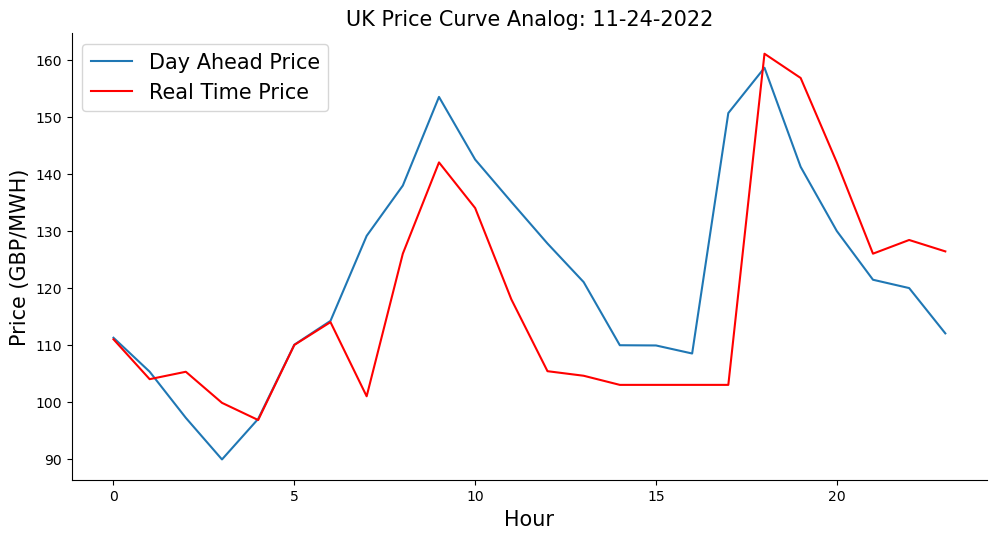

<Figure size 640x480 with 0 Axes>

In [127]:
# Plot Naive prediction, GRU prediction and Actuals for first 24 hours of the test set (normed values)
len_prediction=[x for x in range(len(prices['Real Time Price']))]
plt.figure(figsize=(10,5))
plt.plot(len_prediction, prices['Day Ahead Price'], label="Day Ahead Price")
plt.plot(len_prediction, prices['Real Time Price'], 'r', label="Real Time Price")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price (GBP/MWH)', size=15)
plt.xlabel('Hour', size=15)
plt.legend(fontsize=15)
plt.title('UK Price Curve Analog: 11-24-2022', size=15)
plt.show();
plt.savefig('Price Curve.png', format='png')

## Calculate baseline estimate overestimate and underestimate profile




In [128]:
import math

def calculate_forecast_penalty(forecast, actual, prices):
    # forecast is a list of 48 half-hourly forecast values, in kWh
    # actual is a list of 48 half-hourly actual values, in kWh
    # prices is a dataframe with 24 day-ahead and real-time wholesale electricity prices, in $/MWh

    misEstDollars = []
    dollarPenalty = 0
    counter = 0

    misEstimate = forecast - actual
    
    for x in misEstimate:
        priceIndex = math.floor(counter / 2) # we only have hourly pricing data
        # print('priceIndex: ', priceIndex)
        if x > 0:
            # overestimate
            dollarPenalty = x * prices.iloc[priceIndex]['Day Ahead Price']
        elif x < 0:
            # underestimate
            # dollarPenalty = -x * (prices.iloc[priceIndex]['Real Time Price'] - prices.iloc[priceIndex]['Day Ahead Price'])
            dollarPenalty = -x * (prices.iloc[priceIndex]['Real Time Price'])
        else:
            dollarPenalty = 0
        misEstDollars.append(dollarPenalty / 1000) # convert MWh to kWh
        counter += 1

    print('\nDollar penalty for misestimation each half-hour: ', misEstDollars)
    TotalDollarPenalty = sum(misEstDollars)
    print('\nTotal dollar penalty for misestimation for the day: ', TotalDollarPenalty)
    return TotalDollarPenalty, misEstDollars
    

In [129]:
# calculate financial penalty for baseline
baselinePenalty, baselinePenaltyHourly = calculate_forecast_penalty(forecast=NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS], 
                           actual=mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], 
                           prices=prices)
baselinePenalty


Dollar penalty for misestimation each half-hour:  [7.544878231098991, 6.924888179890984, 7.522424176799988, 9.320699441155554, 9.595854502650019, 11.047023021060001, 11.423239180329983, 8.578413030030008, 5.709202200000015, 7.74410104252799, 8.824381622666657, 5.255420618114732, 4.366826485510538, 2.995395645599996, 2.754249830299993, 3.472380010099996, 5.919857924400005, 6.710633911800003, 6.533136070999997, 4.969857928999995, 6.141756013400003, 6.256460093799991, 5.445405058999997, 8.544734059000008, 9.414327873520001, 10.500158736760007, 9.64987300000001, 7.9502799104600035, 5.252587948499992, 3.4726450206000083, 1.1344934587999906, 2.796449938199984, 1.4998859793999966, 3.624415541200007, 3.661752989699985, 5.082947041200002, 14.321290809551284, 11.28098888136748, 18.63340636080001, 19.955779247040006, 16.34086304260002, 17.37568784380001, 20.40456593700001, 19.440792201600004, 16.951239625679992, 14.632206994559994, 17.5100656, 21.010966437920015]

Total dollar penalty for misest

435.4988886994943

In [130]:
# calculate financial penalty for model
modelPenalty, modelPenaltyHourly = calculate_forecast_penalty(forecast=testYhat[0,:,-1], 
                           actual=mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], 
                           prices=prices)
modelPenalty


Dollar penalty for misestimation each half-hour:  [3.9667675815784147, 7.533373058819042, 7.651230224600864, 8.46931535296968, 6.506597760920786, 3.4800436757239415, 1.9730940359403069, 4.150417947952732, 2.3181110549358825, 1.5070960263701207, 14.809653395968748, 6.767922004124198, 0.4409320243732316, 3.287938224517334, 4.360208328183381, 0.4586754329515575, 3.6158039973562555, 5.496963805068755, 4.160951325195309, 6.067772061074992, 4.938916935003128, 4.736881444768745, 0.8711137441558777, 0.20668763449124386, 0.916809701596876, 9.235638879749388, 13.661366355576568, 15.898779732399698, 9.404944231703125, 11.158345362231259, 10.515727010999997, 11.526993473356244, 8.397664732937505, 6.91306645933438, 5.996586481979684, 8.797228179153134, 18.580211377195642, 17.912532669477415, 14.816501979825002, 15.367887566010005, 16.014067735800005, 13.41321310905626, 12.616574117568751, 15.76193540158126, 11.824073594632488, 4.910039419357506, 1.9209272312275087, 6.04793858794251]

Total dollar 

369.38552046773657

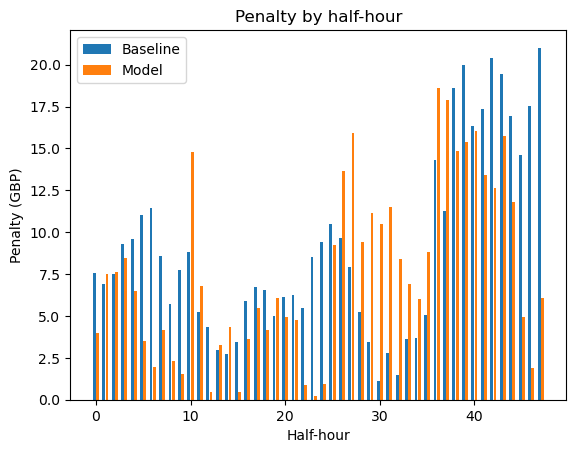

In [131]:
# plot penalty by hour
x = np.arange(len(modelPenaltyHourly))
width = 0.3

plt.bar(x - 0.17, baselinePenaltyHourly, width, label='Baseline')
plt.bar(x + 0.17, modelPenaltyHourly, width, label='Model')
plt.ylabel(f'Penalty (GBP)')
plt.xlabel(f'Half-hour')
_ = plt.legend()
plt.title(f'Penalty by half-hour')
plt.savefig('Penalty by half-hour.png', format='png')

In [132]:
modelBenefit = baselinePenalty - modelPenalty
modelBenefitPerCustomer = modelBenefit / 4987
print('\nBaseline penalty: ${:,.2f}'.format(baselinePenalty))
print('Model penalty: ${:,.2f}'.format(modelPenalty))
print('Net Model absolute benefit: ${:,.2f}'.format(modelBenefit))
print('Net Model benefit: {:,.2f}'.format((baselinePenalty - modelPenalty) / baselinePenalty * 100), '%')
print('Net Model benefit per customer: ${:,.2f}'.format(modelBenefitPerCustomer))


Baseline penalty: $435.50
Model penalty: $369.39
Net Model absolute benefit: $66.11
Net Model benefit: 15.18 %
Net Model benefit per customer: $0.01
